# Risk Management

Portfolio risk value analysis.

The following code proposes a calculation methodology for assessing a portfolio's risk exposure. The statistical analyses performed on the funds [SGR Emerging Countries, SGR Globale, SGR Italia, SGR Strategia Dinamica Globale, SGR Breve Termine, SGR Perfromance, SGR Far East] were evaluated by analyzing a daily data pool for a time period of approximately 3 years.


## Library and Data cleaning

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import Functions_Risk as fr
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

df = pd.read_excel("Business_Case_Valore_Rischio.xlsx", sheet_name='NAV_Fondi')
df.columns = df.iloc[0]  
df = df.drop(0, axis=0)  

df.set_index("Date")

0               EM      GL      IT     LA      LI      MO     PA     PE  \
Date                                                                      
2015-01-02   6.371  11.724  18.763  3.925  14.415  21.335  4.756    NaN   
2015-01-05   6.401  11.624  18.296  3.915  14.391  21.346  4.787    NaN   
2015-01-07   6.467  11.619  18.038  3.915  14.309  21.409  4.717    NaN   
2015-01-08   6.536  11.819  18.552  3.946  14.331  21.581  4.768    NaN   
2015-01-09   6.548  11.748  18.098  3.943  14.329  21.581  4.775    NaN   
...            ...     ...     ...    ...     ...     ...    ...    ...   
2025-01-03  10.348  17.203  24.516  4.913  15.838  22.846  8.979  5.625   
2025-01-07  10.408  17.246  24.949  4.937  15.868  22.862  8.894  5.653   
2025-01-08  10.392  17.241  24.828  4.928  15.882  22.893  8.912  5.641   
2025-01-09  10.364  17.212  24.834  4.923  15.893  22.938  8.834  5.638   
2025-01-10  10.258  17.057  24.568  4.897  15.863  22.847  8.809   5.62   

0              RI     SC     SM  
Date                             
2015-01-02    NaN    NaN    NaN  
2015-01-05    NaN    NaN    NaN  
2015-01-07    NaN    NaN    NaN  
2015-01-08    NaN    NaN    NaN  
2015-01-09    NaN    NaN    NaN  
...           ...    ...    ...  
2025-01-03  5.288  6.383  5.796  
2025-01-07  5.289  6.375  5.778  
2025-01-08  5.289  6.365  5.772  
2025-01-09  5.289  6.373  5.776  
2025-01-10  5.288  6.316  5.738  

[2512 rows x 11 columns]

## 1) Graphic analysis


The following shows the **price** performance of the portfolio stocks, the **log returns**.
It should be noted that not all stocks have the same **number of measurements**; in particular, for SGR Risparmio, SGR Strategia di Crescita, and SGR Strategia Moderata, historical series covering approximately the last 3 years are present.
This will result in a more sensitive measurement and less accuracy in the summary statistics.

### Price trend charts

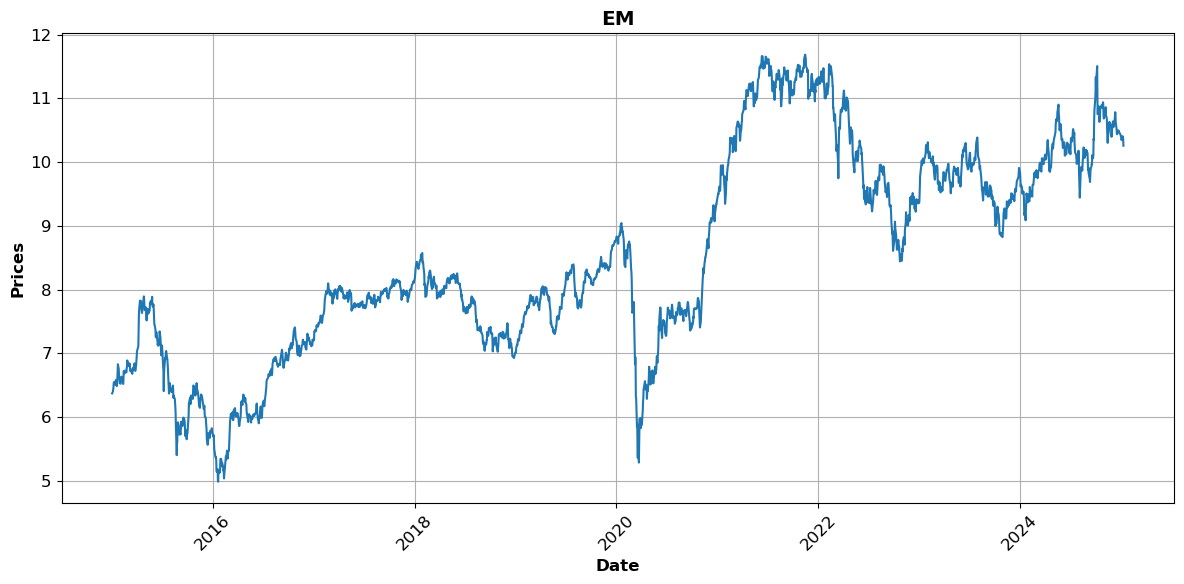

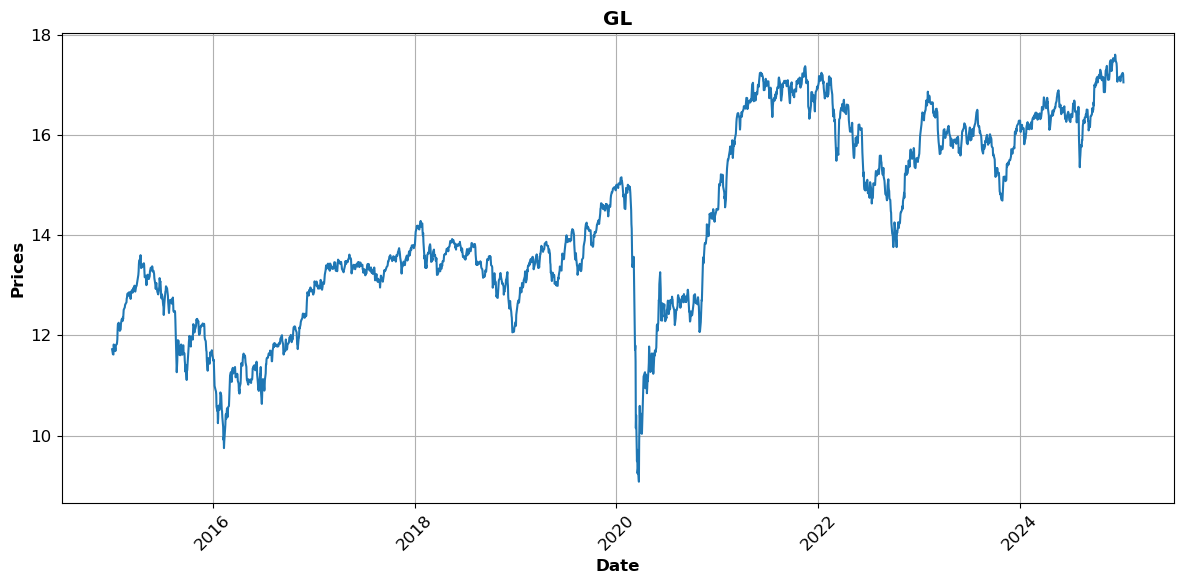

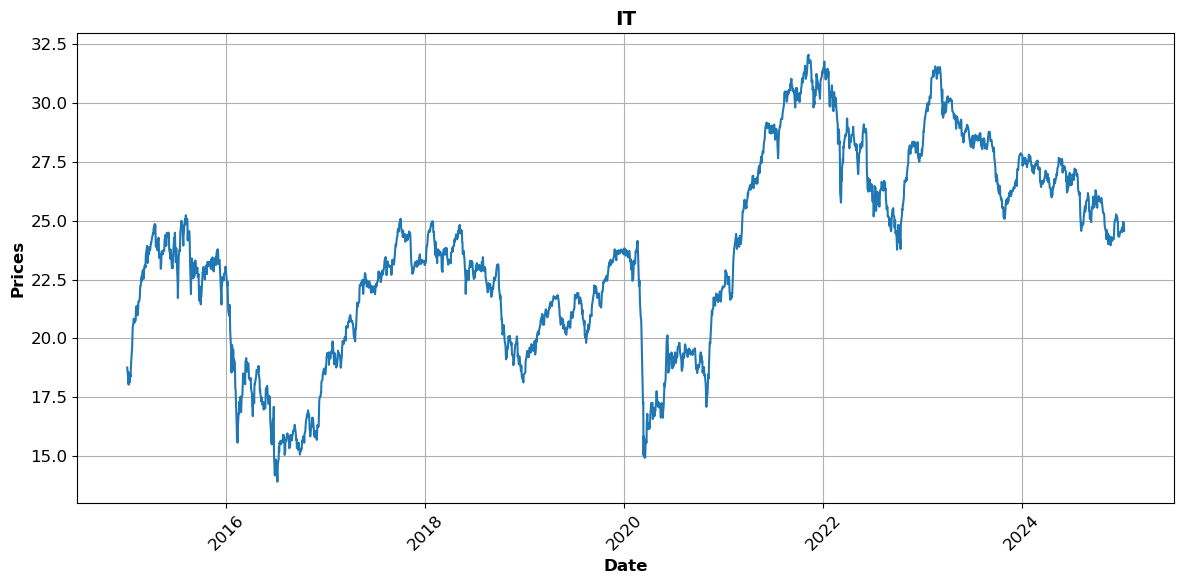

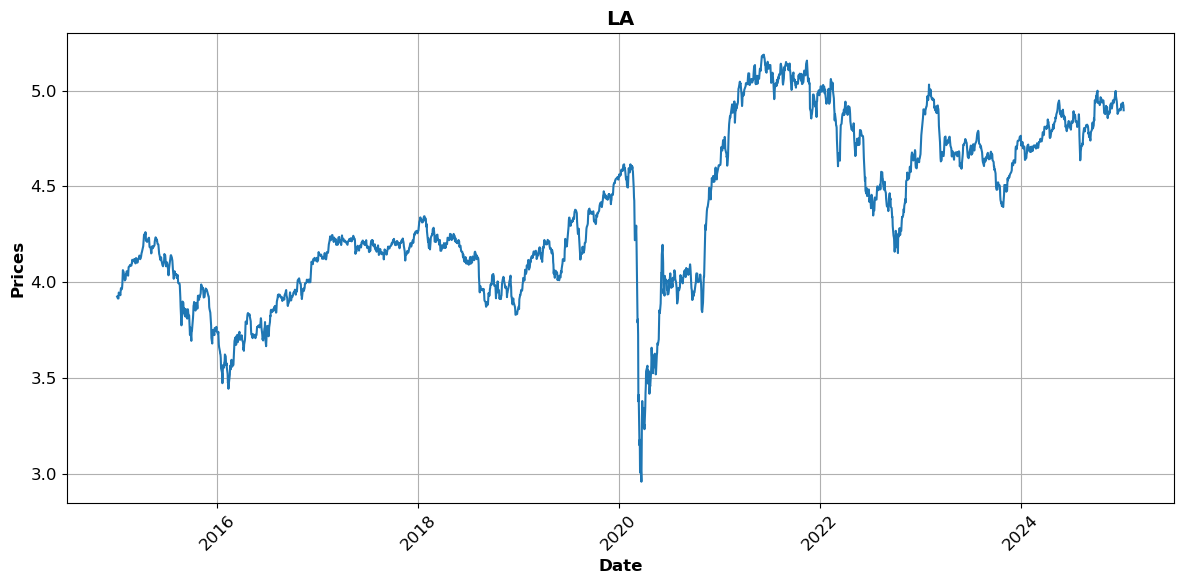

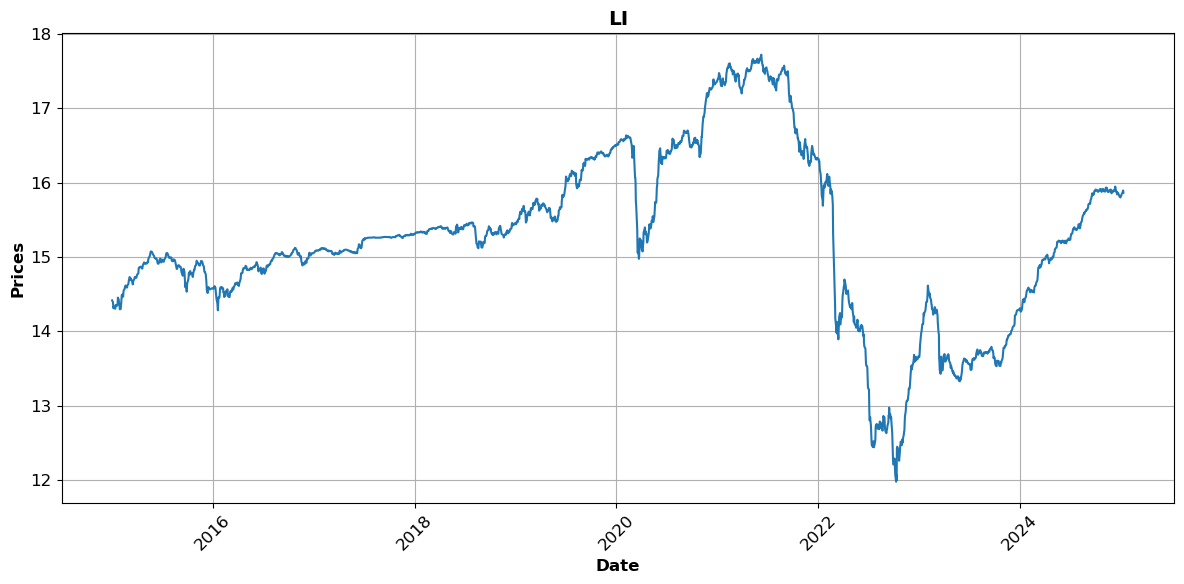

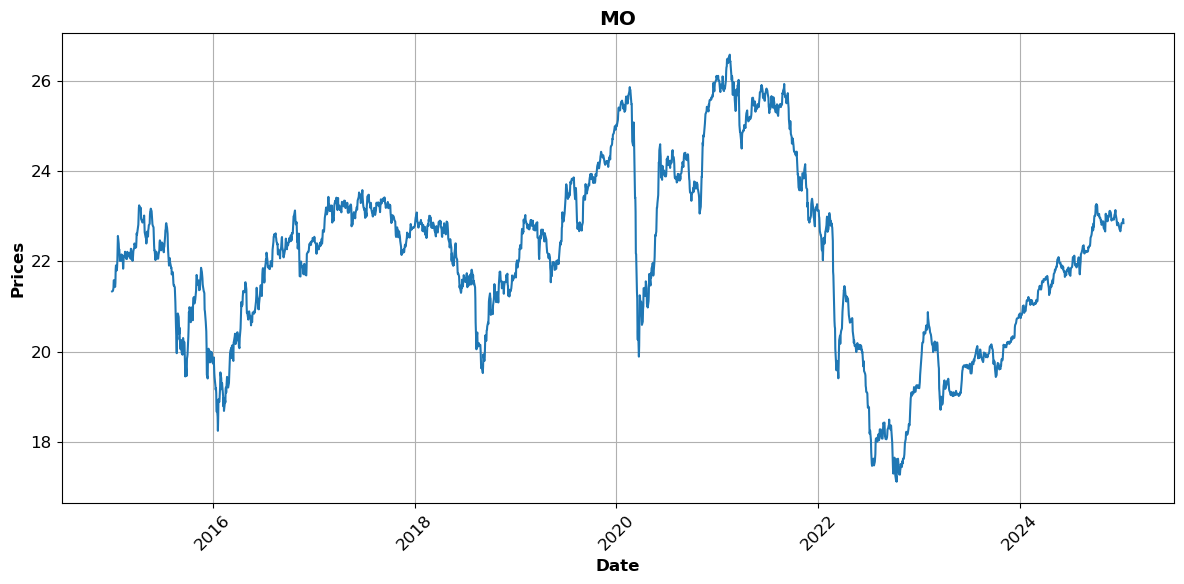

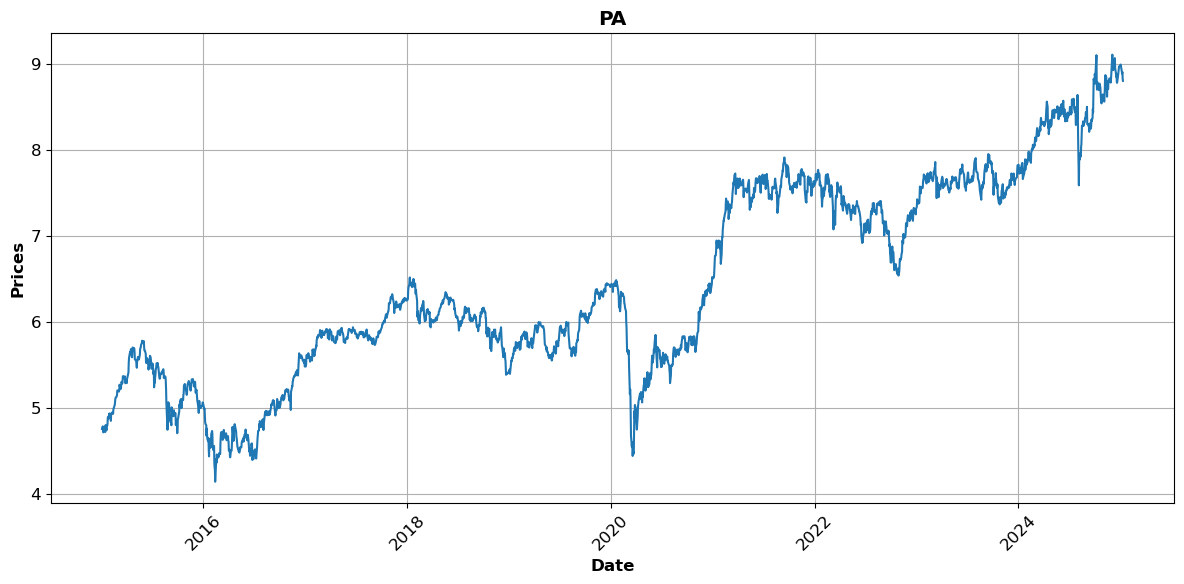

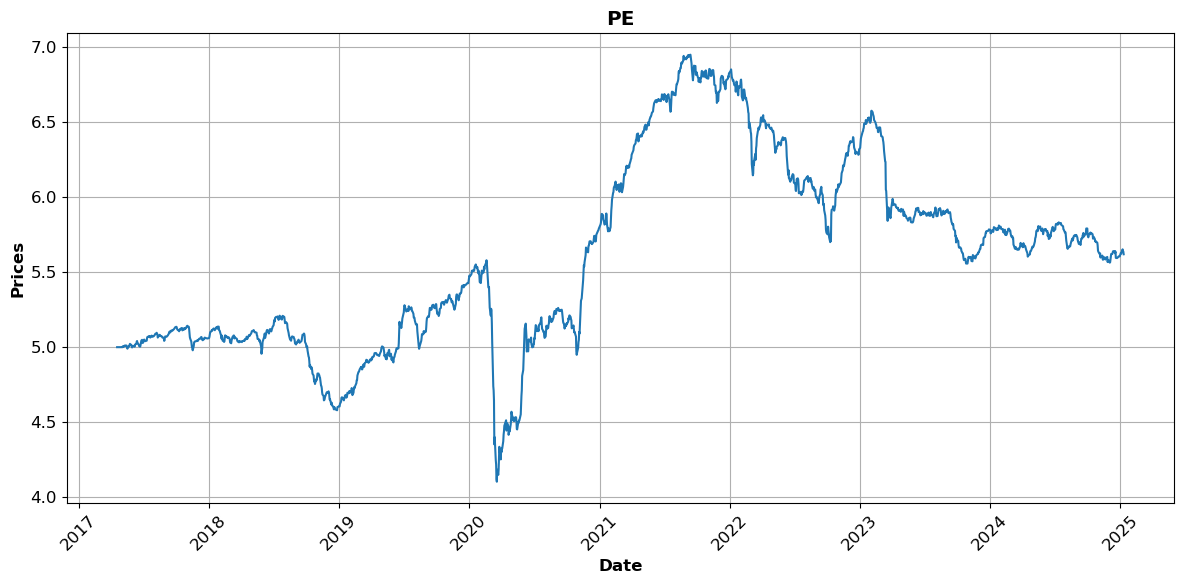

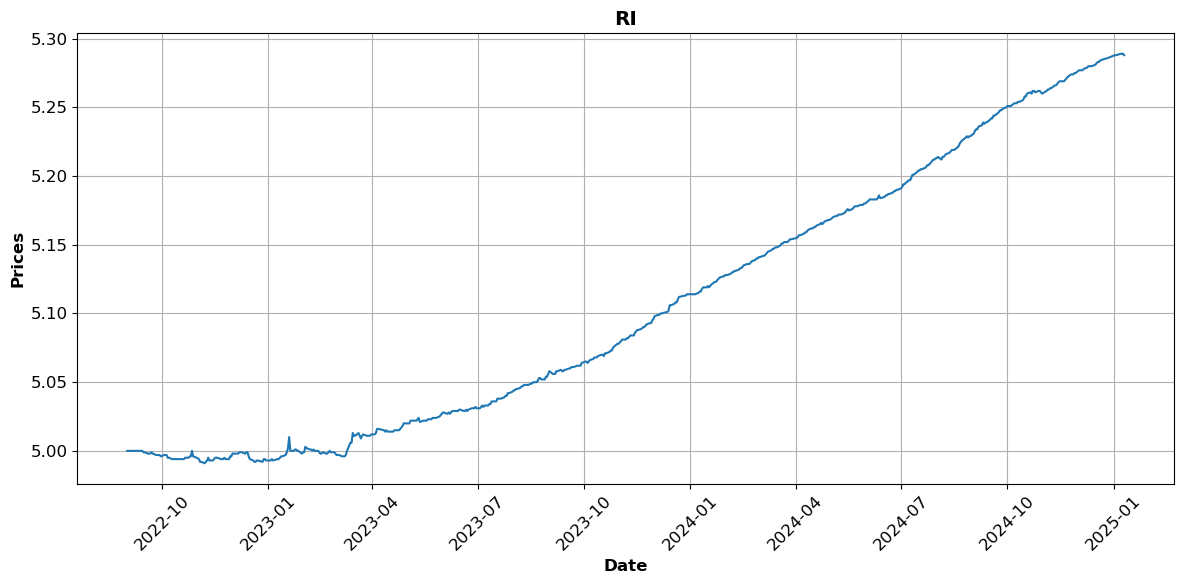

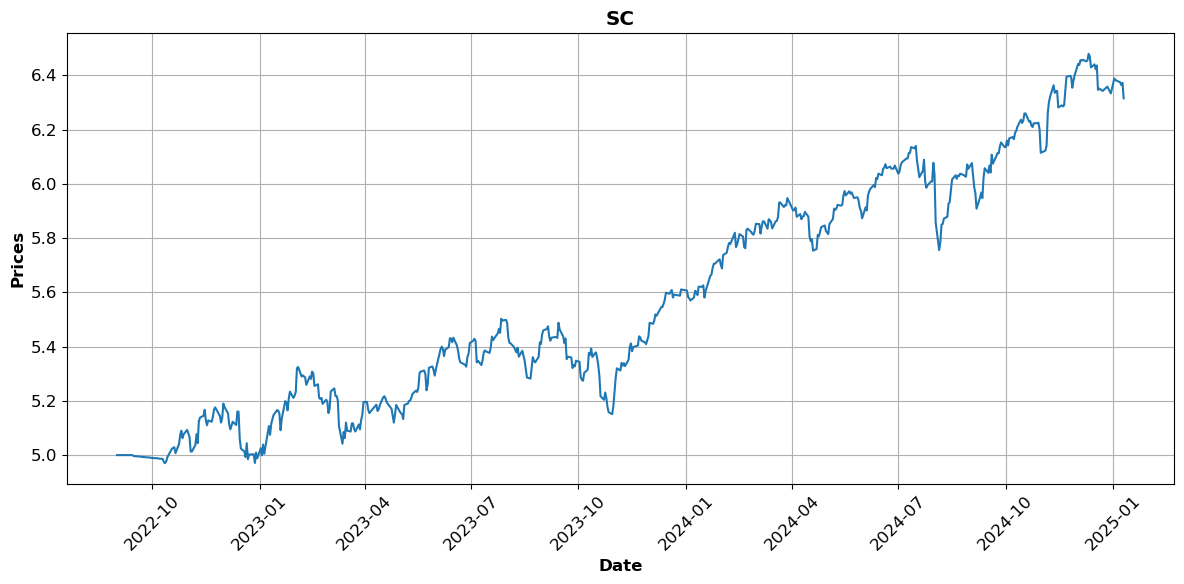

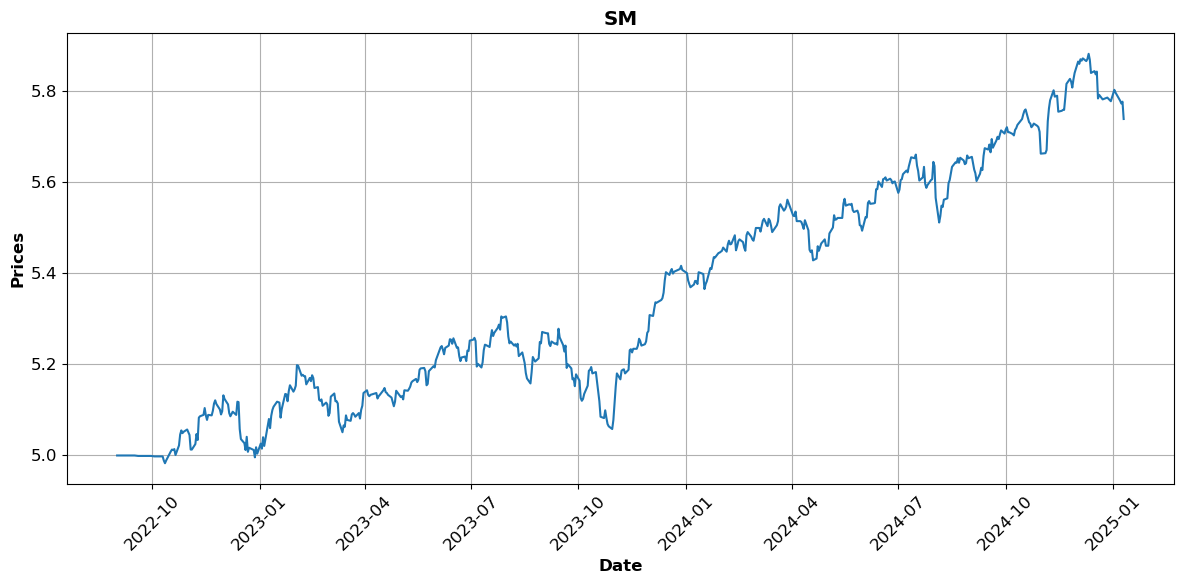

In [2]:
Titles = ['EM', 'GL', 'IT', 'LA', 'LI', 'MO', 'PA', 'PE', 'RI', 'SC', 'SM']
fr.Plot_Prices(df, Titles)

### Number of measurements

In [3]:
df.index = df["Date"]
df = df.drop(columns = ["Date"])
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2512 entries, 2015-01-02 to 2025-01-10
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EM      2512 non-null   float64
 1   GL      2512 non-null   float64
 2   IT      2512 non-null   float64
 3   LA      2512 non-null   float64
 4   LI      2512 non-null   float64
 5   MO      2512 non-null   float64
 6   PA      2512 non-null   float64
 7   PE      1936 non-null   float64
 8   RI      590 non-null    float64
 9   SC      590 non-null    float64
 10  SM      590 non-null    float64
dtypes: float64(11)
memory usage: 235.5 KB


####  Logarithmic Returns Charts

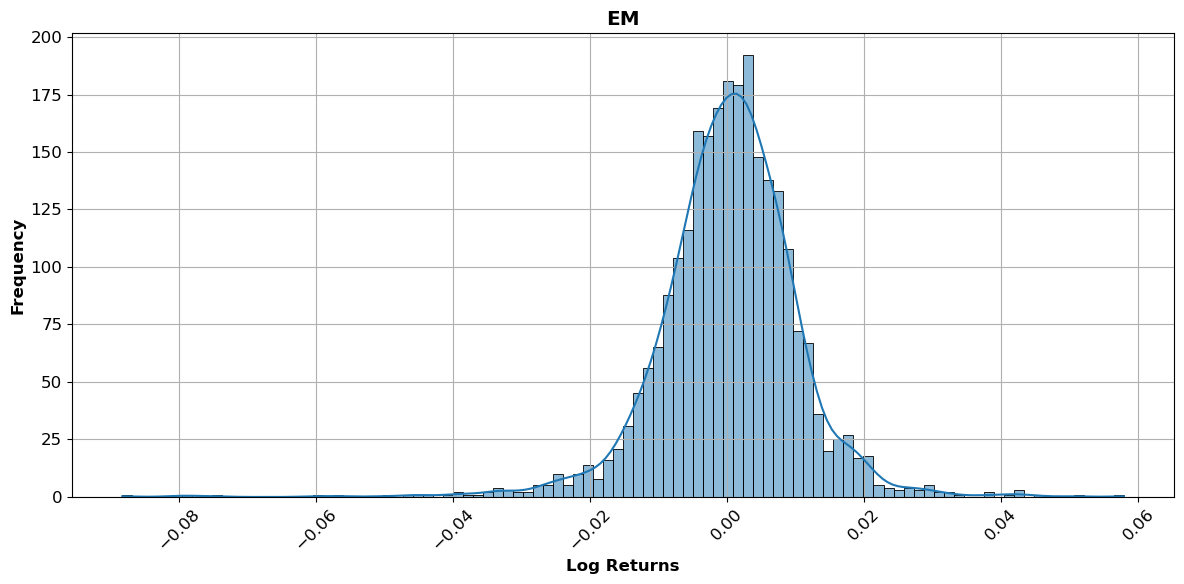

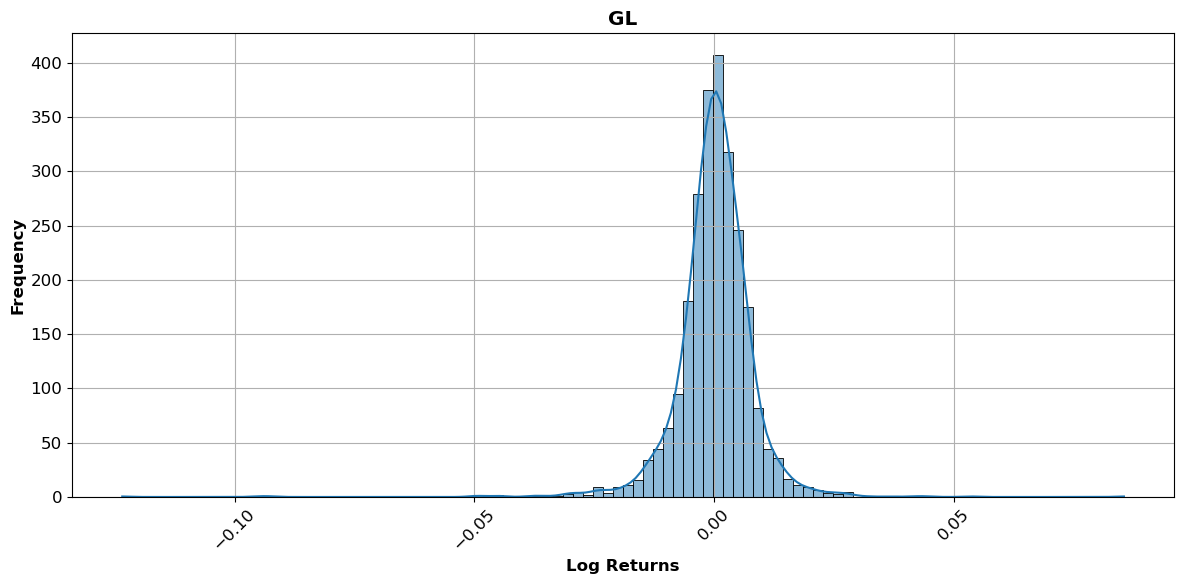

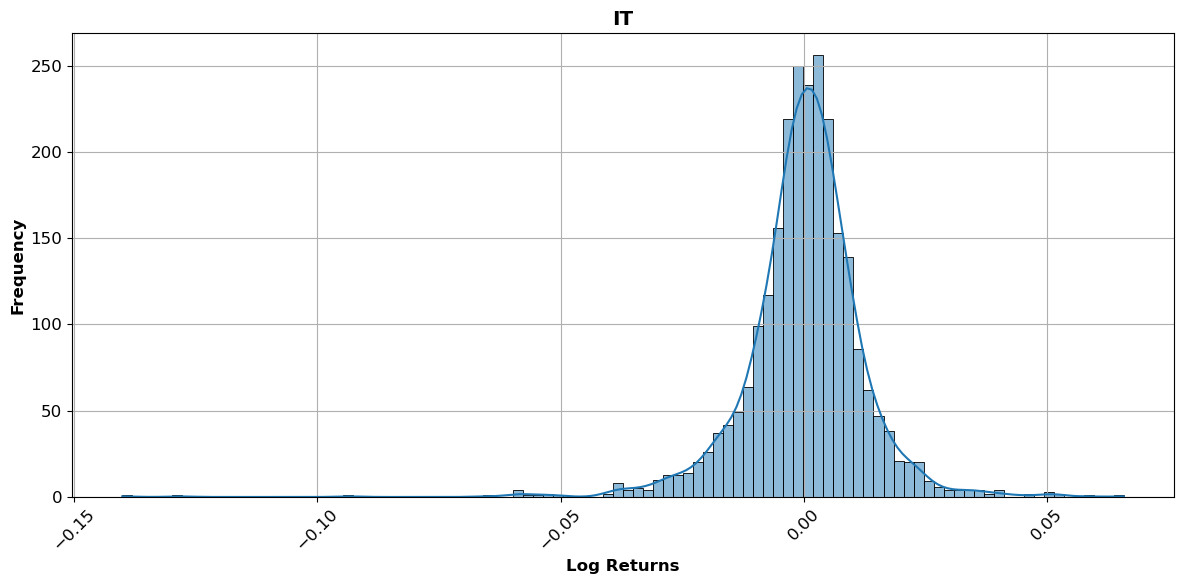

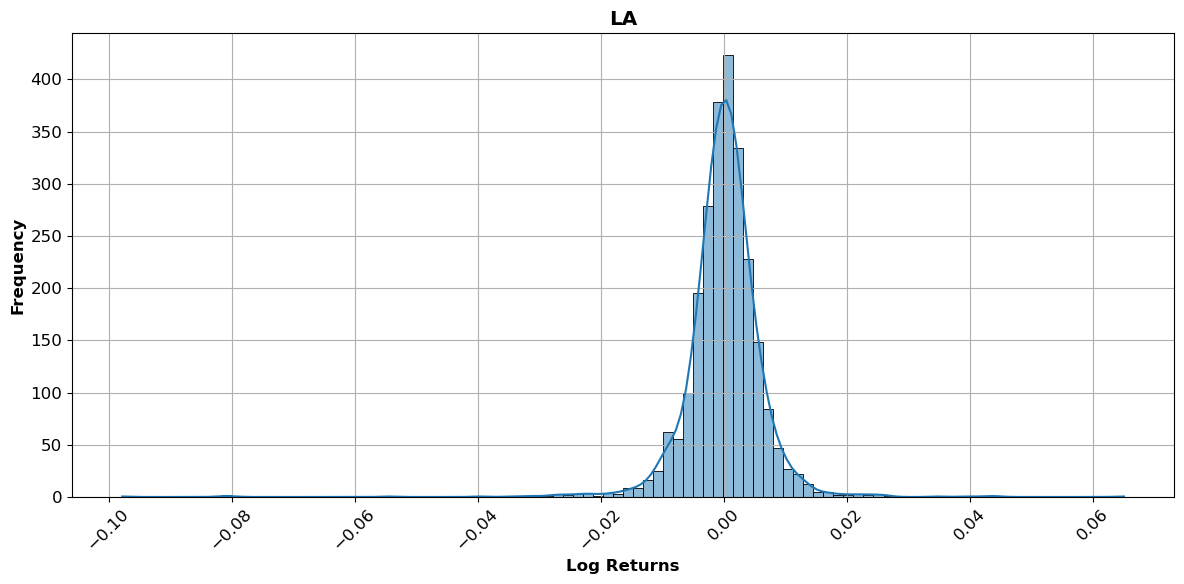

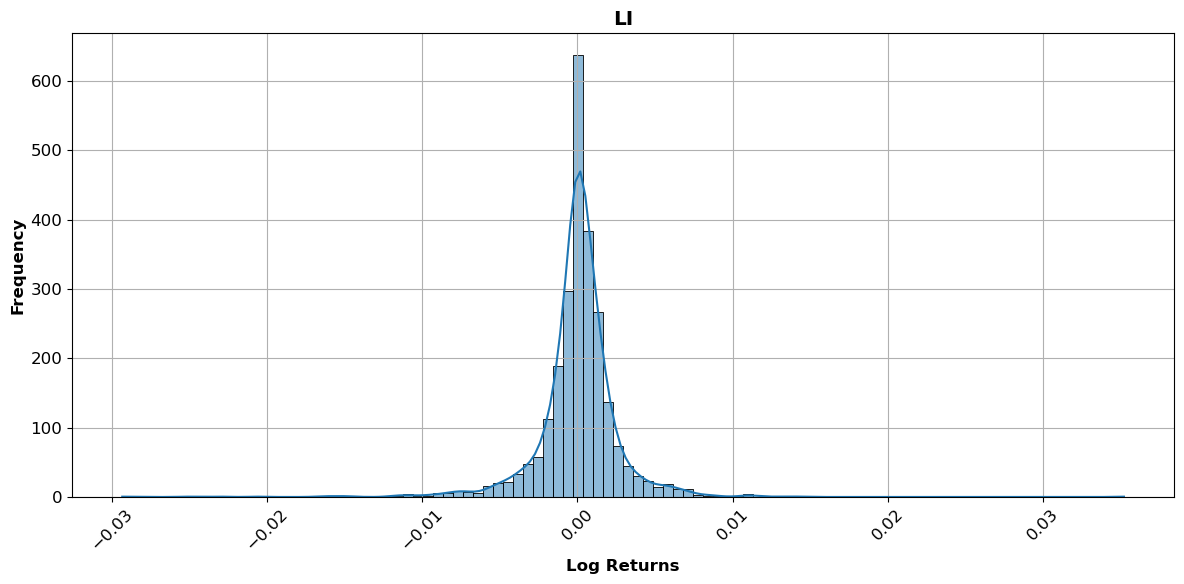

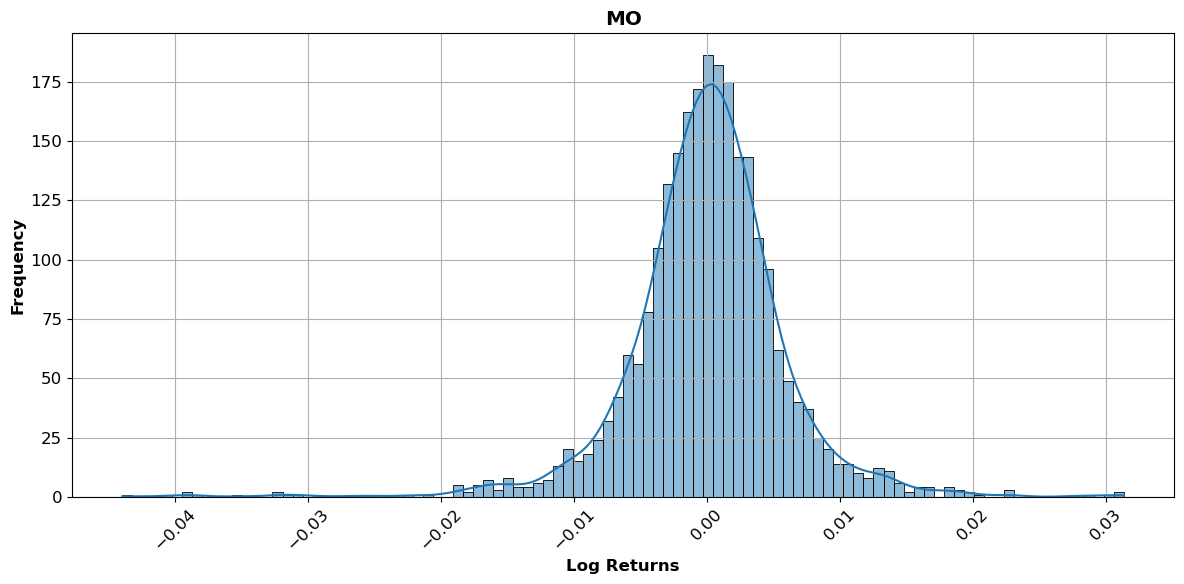

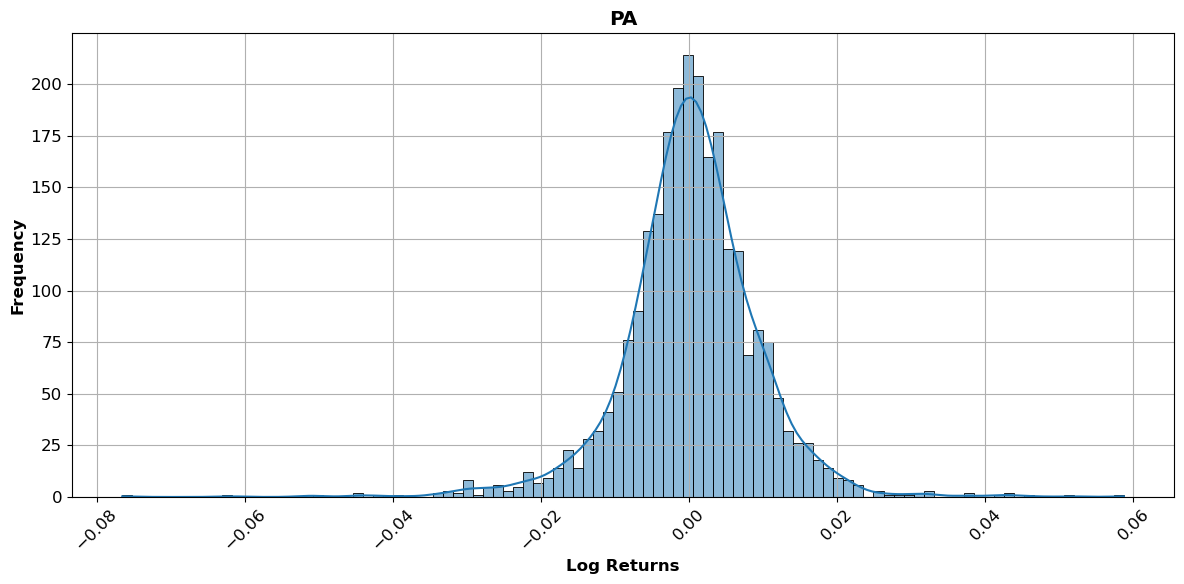

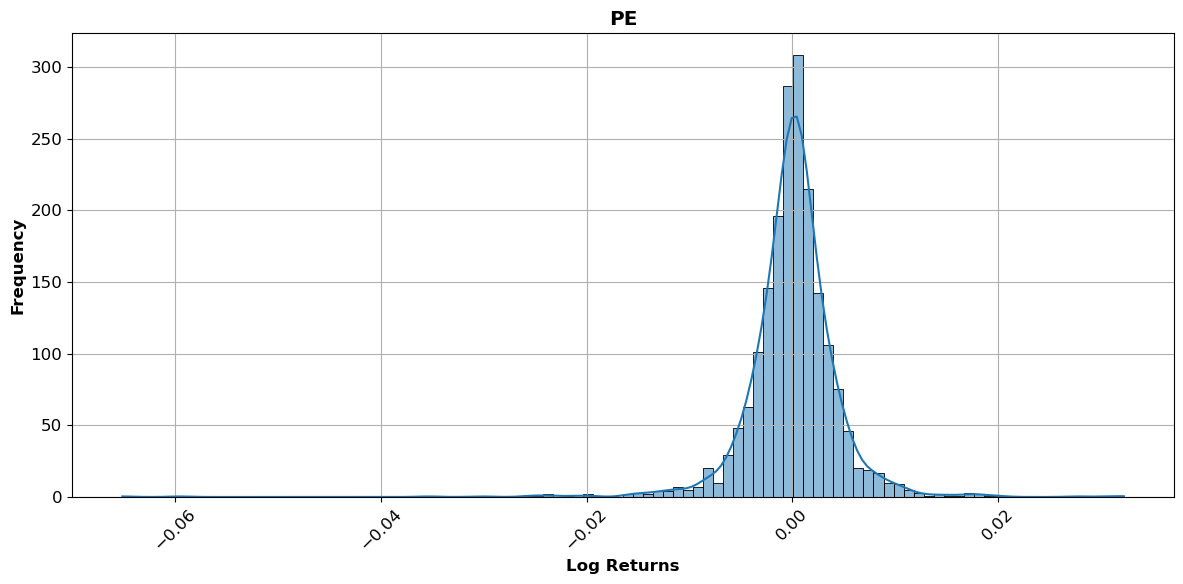

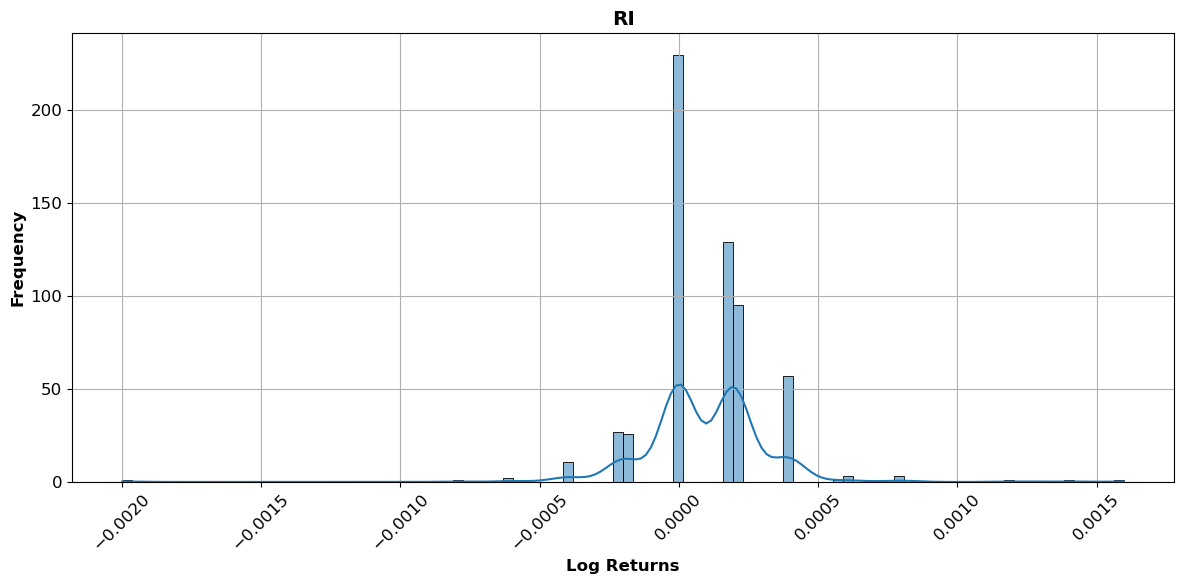

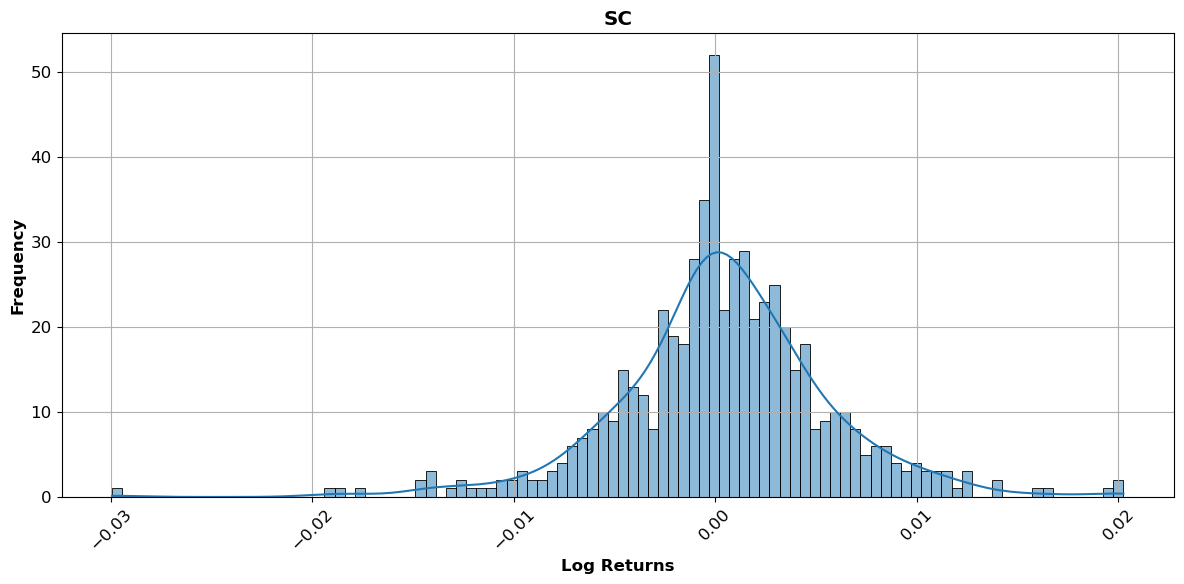

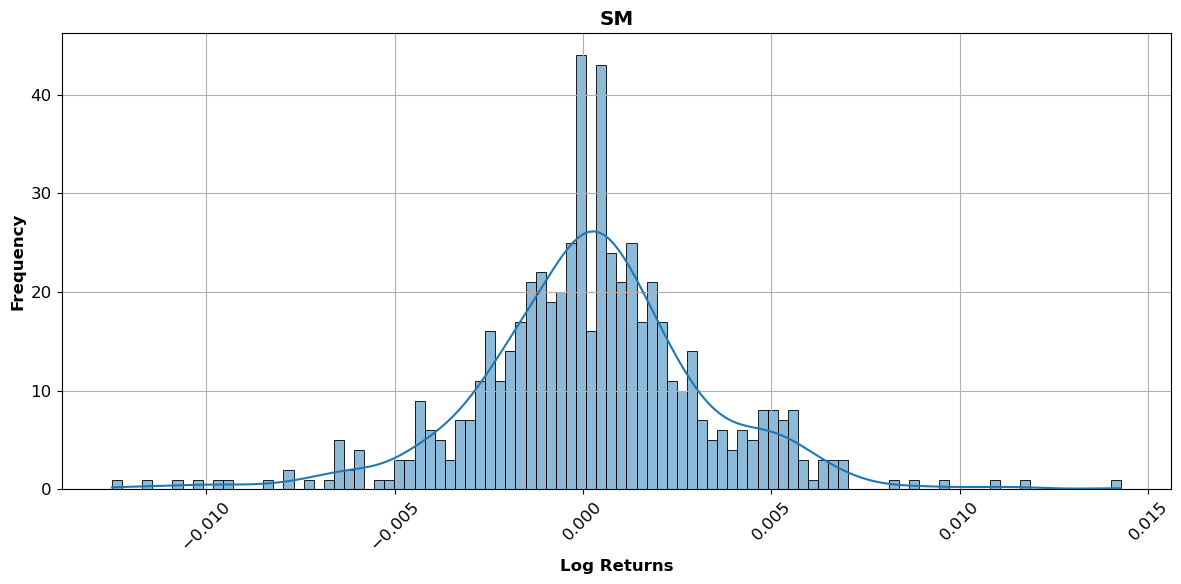

In [4]:
df_Log_Returns = np.log(df/df.shift(1))
df_Log_Returns = df_Log_Returns[1:]
fr.Plot_LogReturns(df_Log_Returns, Titles)

## 2) Summary Statistics
Below are the summary statistics for the relevant funds.
For each fund, determine the summary statistics, such as:

- Volatility (over various "windows" and measurement units, e.g., 1D, 1M, 1Y)
- Correlation matrices BETWEEN funds (with significance tests if possible)

### Return over the entire period

List of fund total returns over the entire number of measurements. Note that not all securities have the same number of measurements.

In [5]:
Titles = ['EM', 'GL', 'IT', 'LA', 'LI', 'MO', 'PA', 'PE', 'RI', 'SC', 'SM']
100 * fr.Returns_of_Titles(df, Titles)

EM    61.010830
GL    45.487888
IT    30.938549
LA    24.764331
LI    10.045092
MO     7.086946
PA    85.218671
PE    12.400000
RI     5.760000
SC    26.320000
SM    14.760000
dtype: float64

### Volatility and Period Returns [1D, 1M, 1Y]
- **Volatility and return over different time windows**:
Let \( R_t \) be the series of daily returns and \( w \) be the window size (in days: 1, 21, 252 per day, month, year).
Then:

$$
\sigma_w = \text{std}(R_t)_{t \in [t-w+1, t]}
\qquad
\mu_w = \text{mean}(R_t)_{t \in [t-w+1, t]}
$$

where \( $\sigma_w$ ) and \( $\mu_w$ ) represent the volatility and the average return, respectively, calculated over a moving window of width \( **w** \).

#### Moving Average

To analyze price or return trends over different time frames, moving averages (SMAs) are calculated over the same time frames (daily, monthly, yearly). The SMA plot allows us to highlight trends and changes in volatility/return over time, smoothing out short-term fluctuations.

Volatility Periods 
0         EM        GL        IT        LA        LI        MO        PA  \
1D  0.010399  0.008488  0.012382  0.006734  0.002704  0.005993  0.009295   
1M  0.009227  0.006771  0.010594  0.005219  0.001930  0.005201  0.008419   
1Y  0.009825  0.007705  0.011891  0.005972  0.002375  0.006021  0.008822   

0         PE        RI        SC        SM  
1D  0.004762  0.000227  0.005303  0.003080  
1M  0.003670  0.000198  0.005068  0.002955  
1Y  0.004724  0.000276  0.005392  0.003182  

Returns Periods (%)
0         EM        GL         IT        LA         LI        MO         PA  \
1D -1.022771 -0.900535  -1.071112 -0.528133  -0.188762 -0.396722  -0.282998   
1M -2.869046 -2.391989  -0.983395 -0.830296  -0.169918 -0.440126  -1.399149   
1Y  6.943286  5.238154 -11.085375  3.640212  10.875795  9.630518  13.051848   

0         PE        RI         SC        SM  
1D -0.319262 -0.018907  -0.894398 -0.657895  
1M  0.303409  0.208452  -2.153369 -2.182066  
1Y -2.683983  3.362

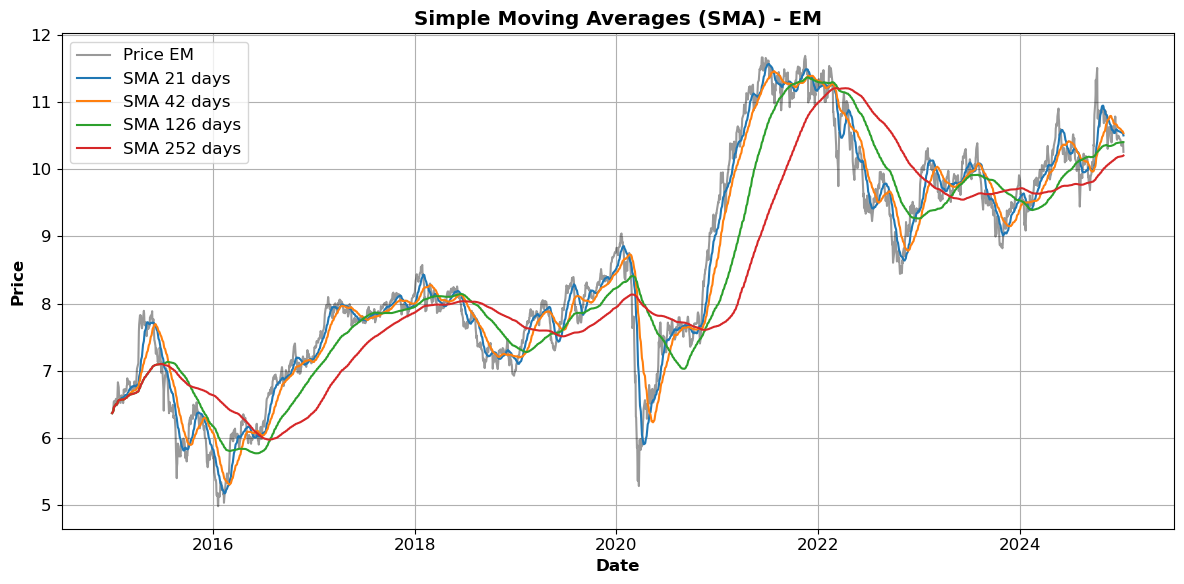

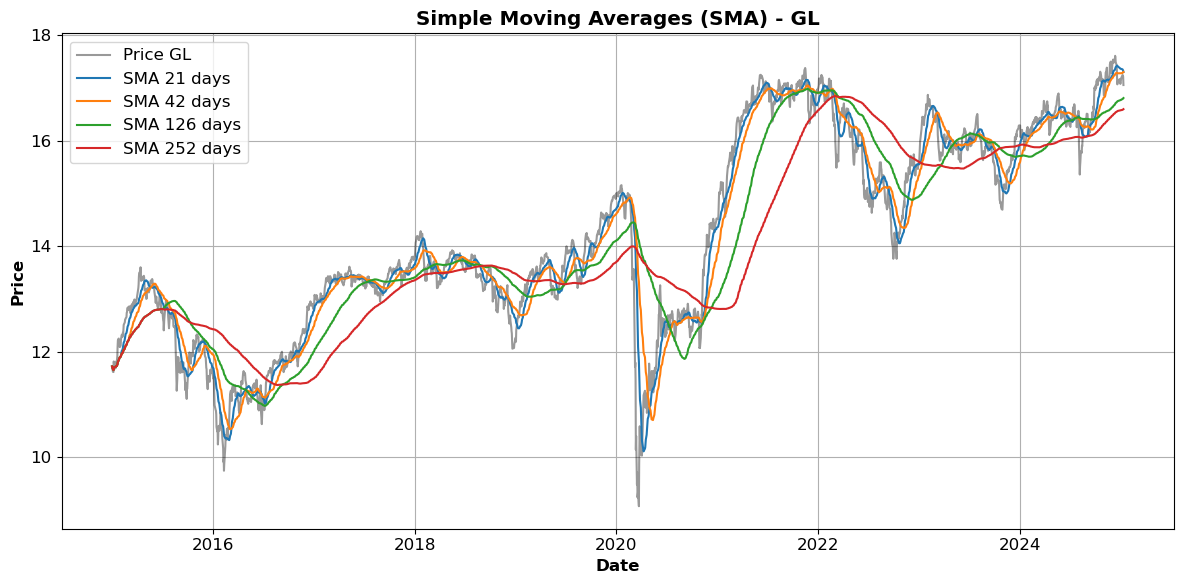

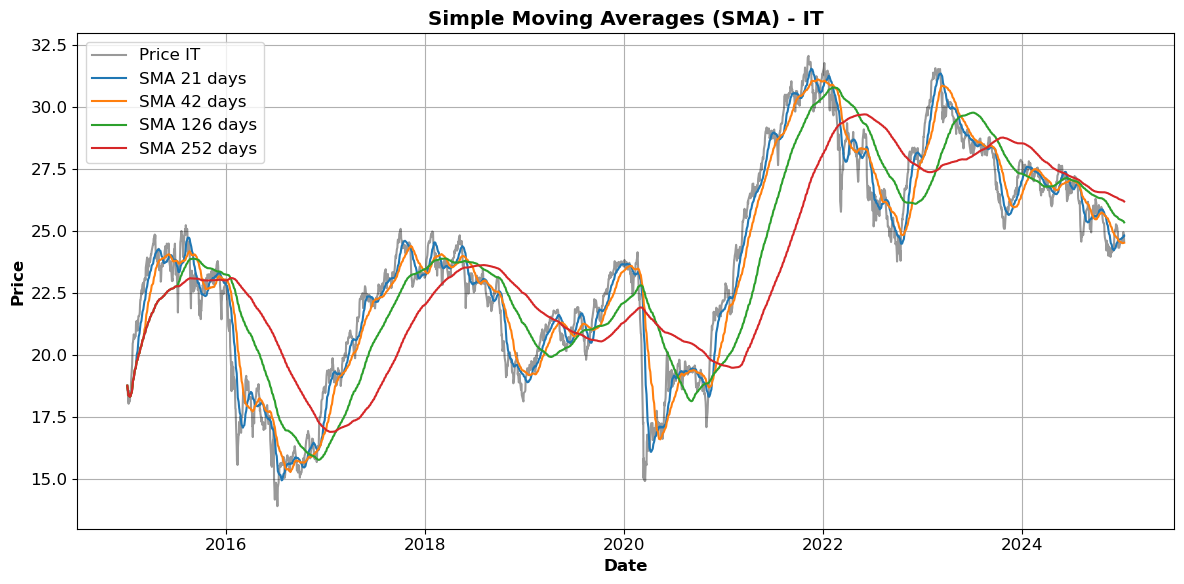

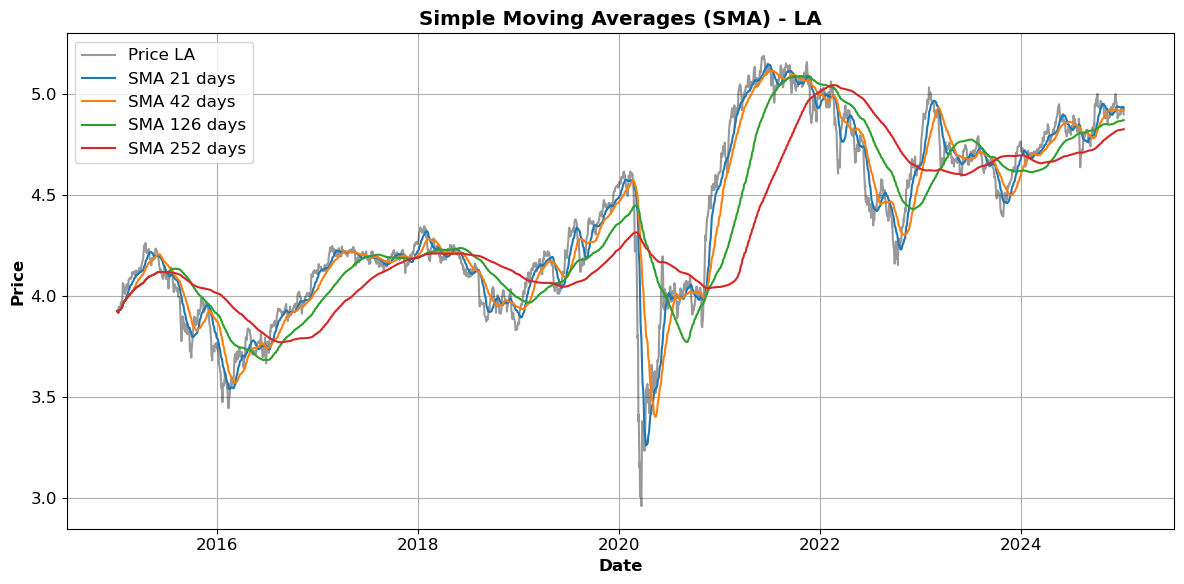

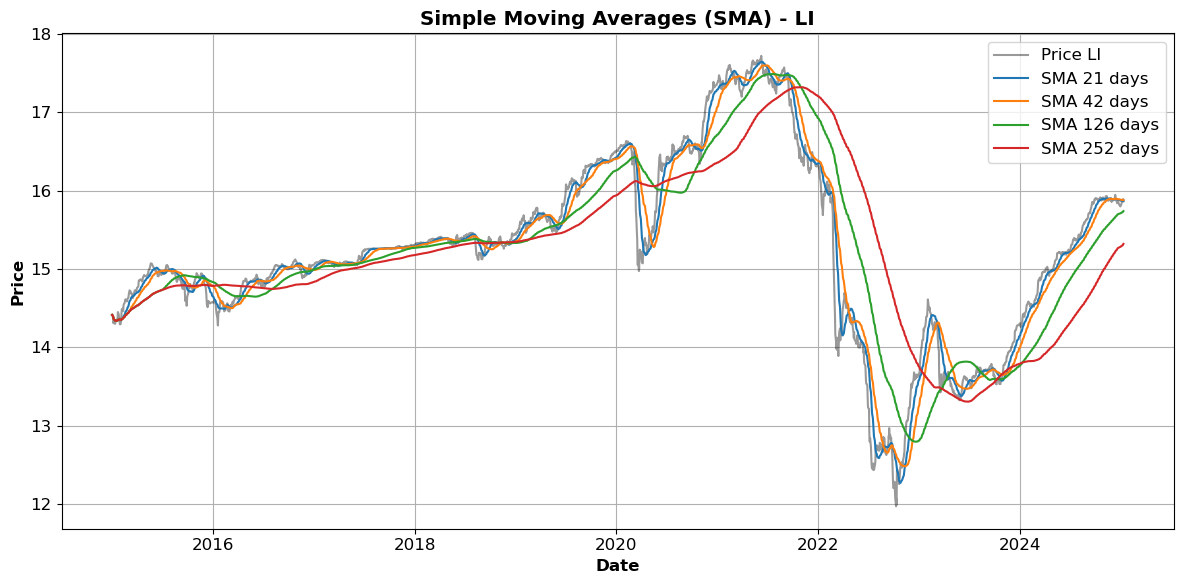

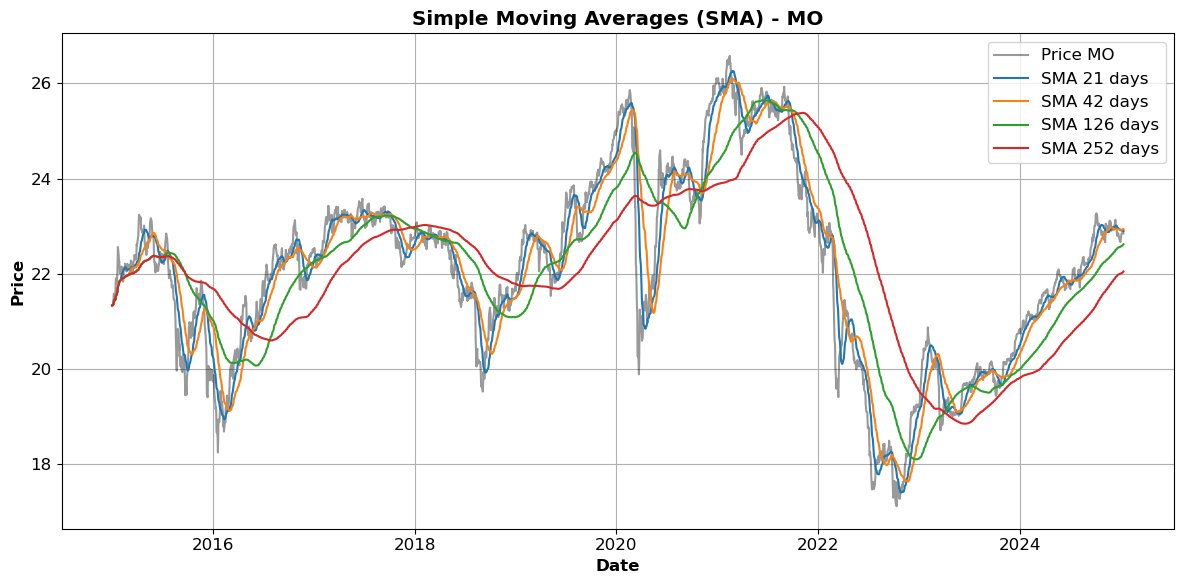

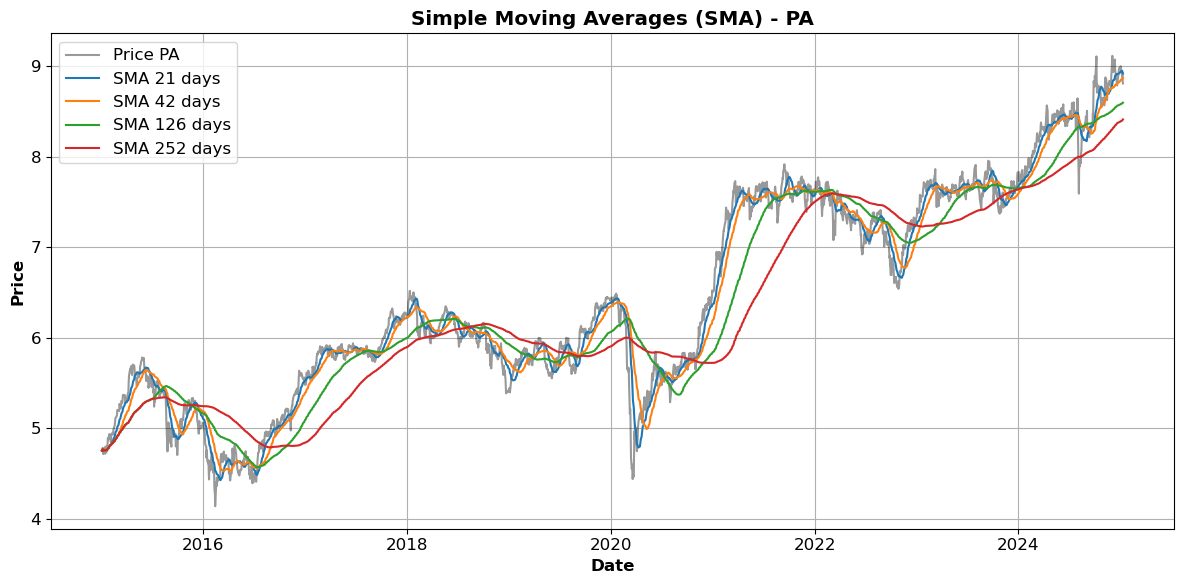

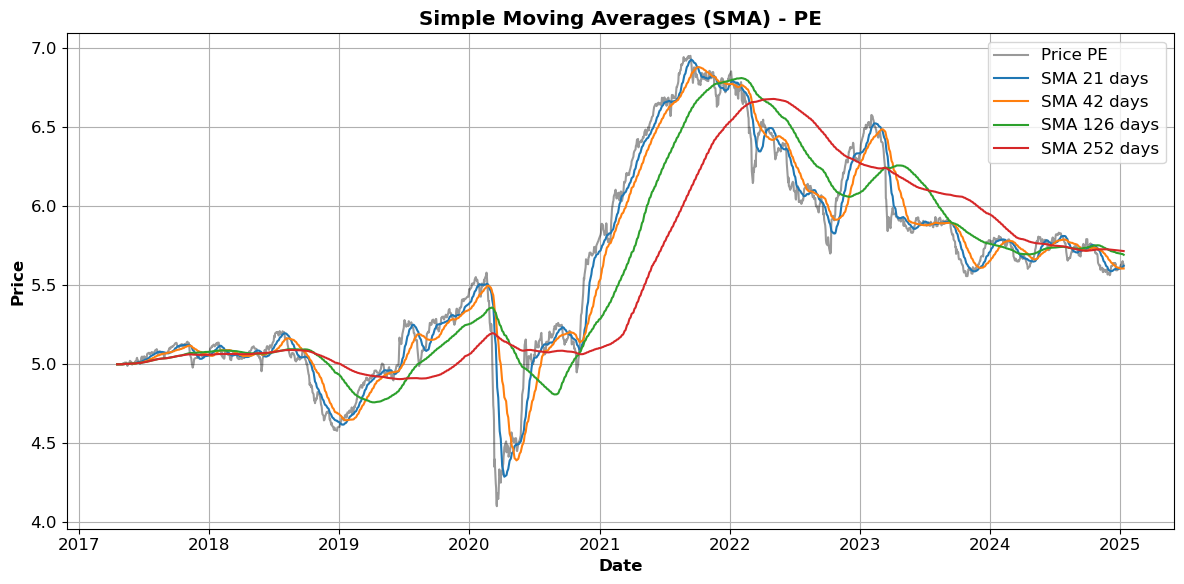

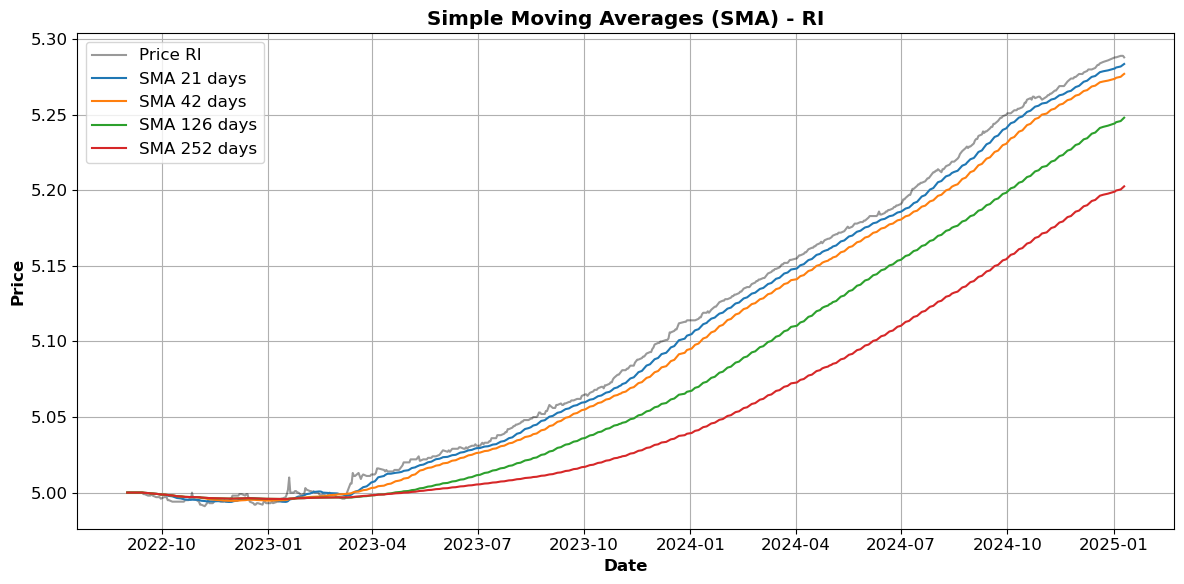

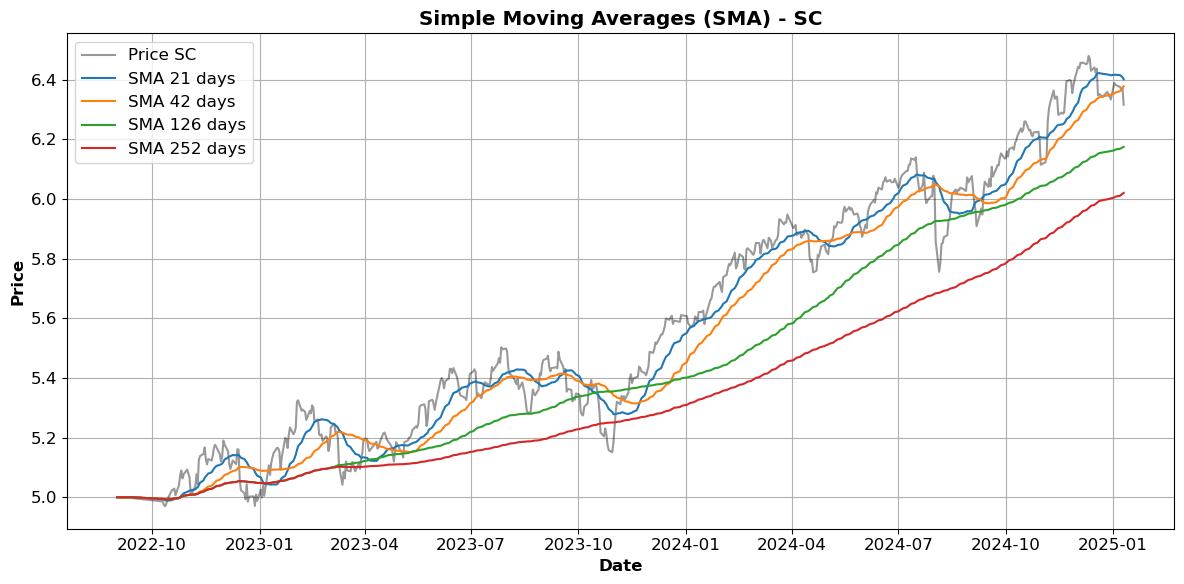

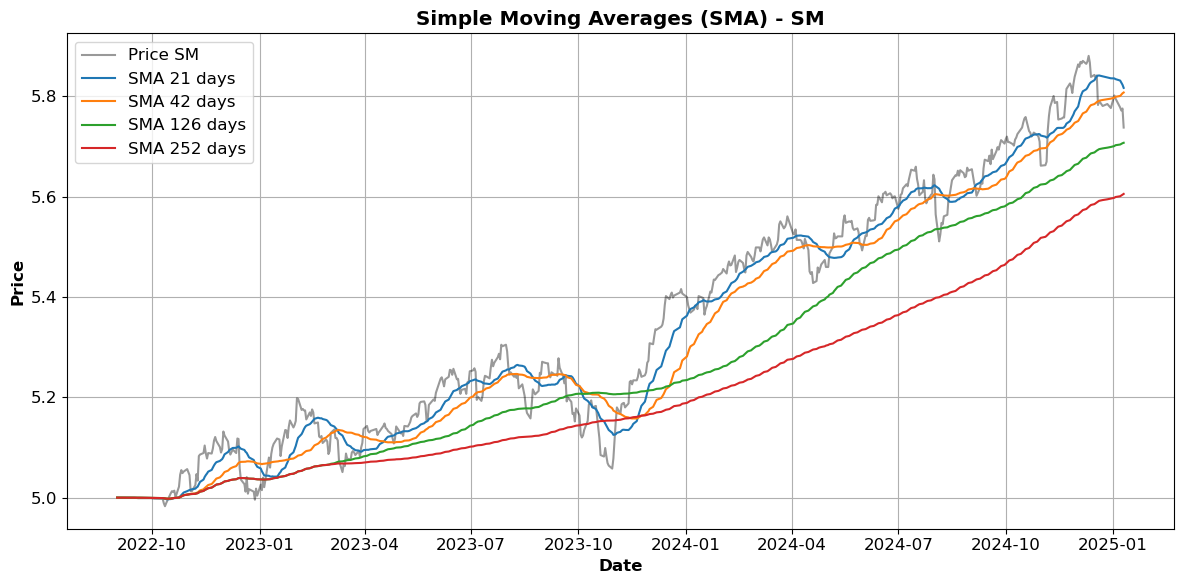

In [6]:
fr.Volatility_Periods(df_Log_Returns)
fr.Returns_Periods(df)

w = [21, 42, 126, 252]  # SMA windows
        
fr.Moving_Average_of_Titles(df, w)

### Correlation Matrix


$$
\Sigma = 
\begin{bmatrix}
\text{Var}(R_1) & \text{Cov}(R_1, R_2) & \dots & \text{Cov}(R_1, R_n) \\
\text{Cov}(R_2, R_1) & \text{Var}(R_2) & \dots & \text{Cov}(R_2, R_n) \\
\vdots & \vdots & \ddots & \vdots \\
\text{Cov}(R_n, R_1) & \text{Cov}(R_n, R_2) & \dots & \text{Var}(R_n)
\end{bmatrix}
$$

**Note**
- The matrix is symmetric, since $\text{Cov}(R_i, R_j) = \text{Cov}(R_j, R_i)$.
- The variance-covariance is typically calculated on a series of historical returns, assuming that the returns are stationary.

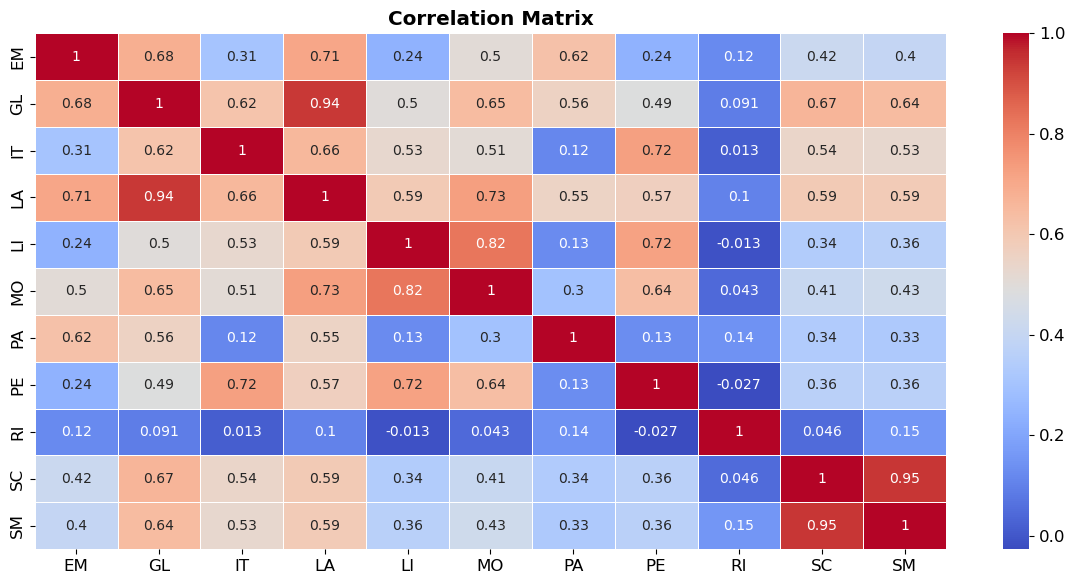

In [7]:
corr_between_funds = df_Log_Returns.dropna().corr() 

plt.title("Correlation Matrix")

sns.heatmap(
    corr_between_funds,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"size": 10})

plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
plt.savefig("img/Covariance_Matrix.png", dpi=500, bbox_inches='tight')

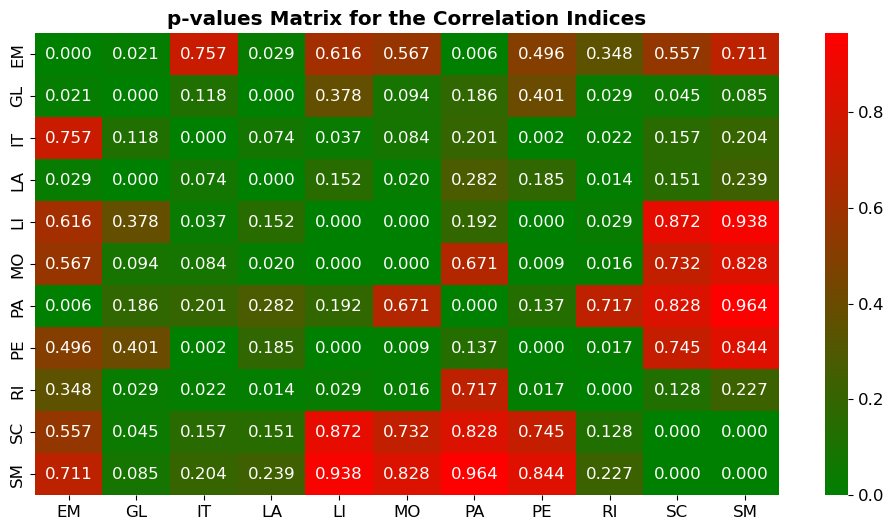

In [8]:
fr.Pearson_Fund_Test(corr_between_funds, Titles)

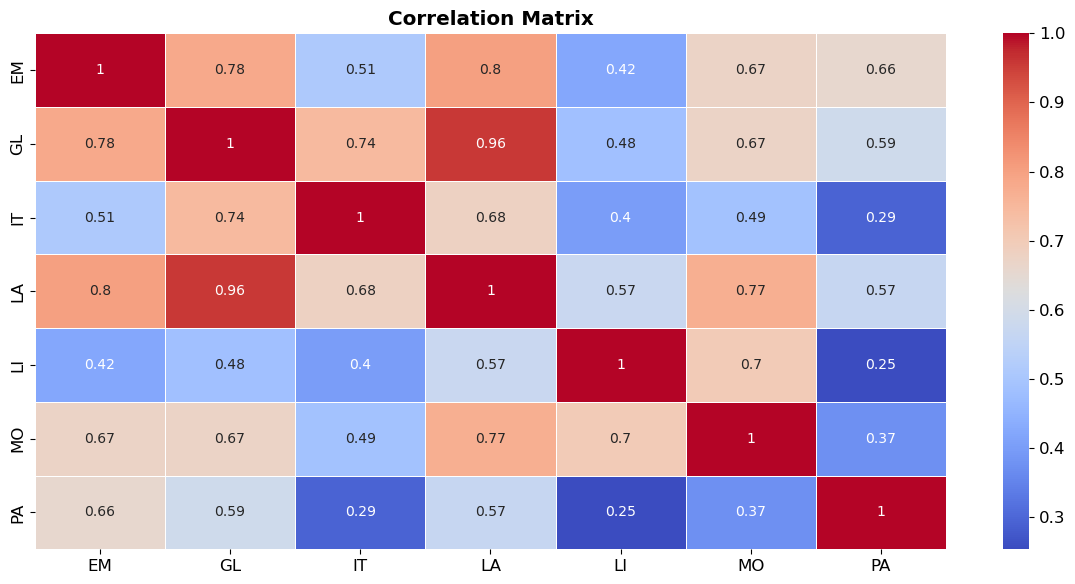

In [9]:
t_corr1 = df_Log_Returns[["EM", "GL", "IT", "LA", "LI", "MO", "PA"]].corr()
plt.title("Correlation Matrix")
sns.heatmap(
    t_corr1,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
plt.savefig("img/Correlation_Mtx_big_funds.png", dpi=300, bbox_inches='tight')

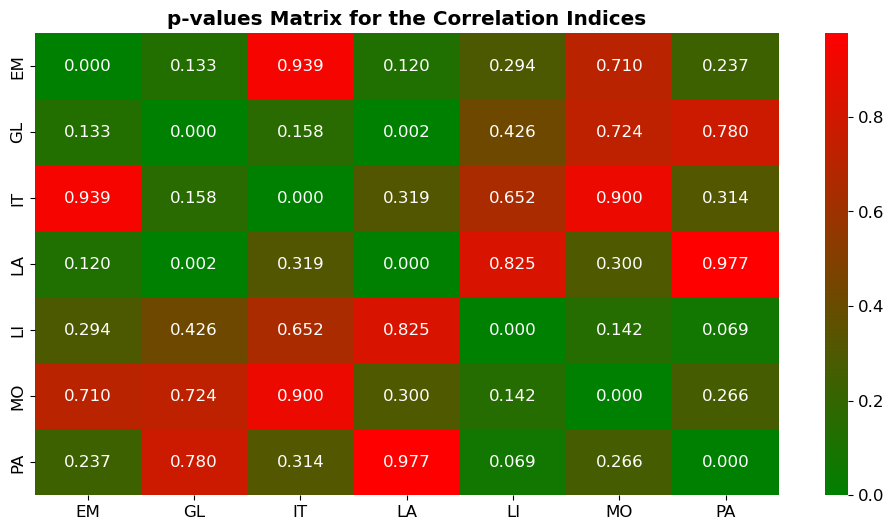

In [10]:
fr.Pearson_Fund_Test(t_corr1, Titles[:7])

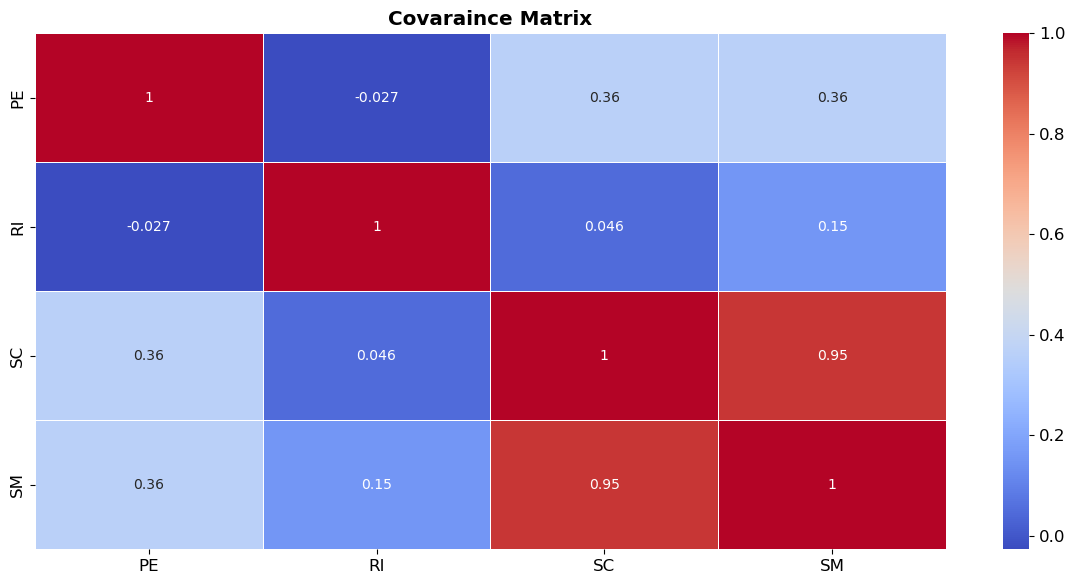

In [11]:
t_corr2 = df_Log_Returns[["PE","RI","SC","SM"]].dropna().corr()
plt.title("Covaraince Matrix")
sns.heatmap(
    t_corr2,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
plt.savefig("img/Corr_MTX_small_funds.png", dpi=300, bbox_inches='tight')

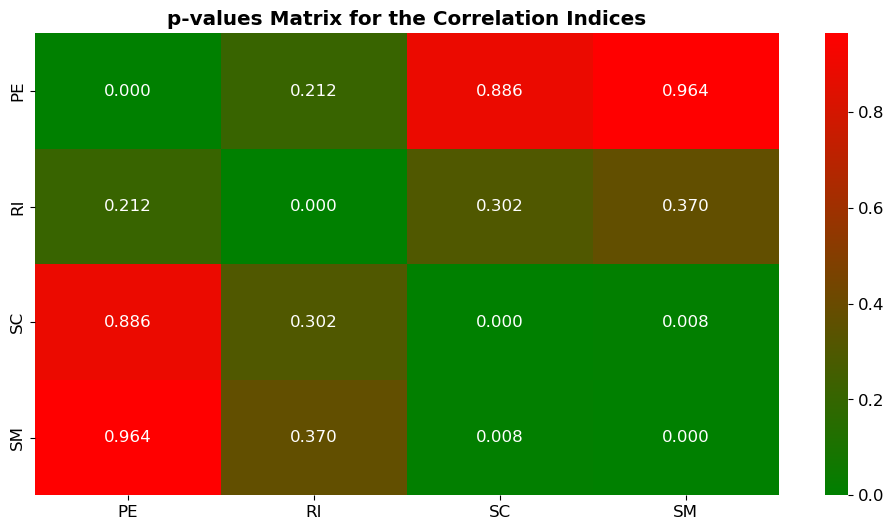

In [12]:
fr.Pearson_Fund_Test(t_corr2, Titles[7:])

# 3) Value at Risk (VaR) estimation

The following code section proposes two strategies for calculating VaR:

- Historical Simulation
- Parametric with Gaussian distribution

### Historical VaR

VaR is evaluated based on the historical trend of logarithmic returns; the value at risk will correspond to the return associated with the percentile chosen as the confidence level of the return distribution.

In [13]:
alpha = 0.05  # VaR confidence level
T = 1 # Time horizon
fr.VaR_Methods(df_Log_Returns, alpha, T)

Parametric %  Gaussian %    Delta %  t-student
VaR                                                
EM      -1.503993   -1.691496  12.467008   1.692128
GL      -1.166860   -1.381194  18.368450   1.381710
IT      -1.904031   -2.025882   6.399632   2.026634
LA      -0.888218   -1.098757  23.703489   1.099166
LI      -0.380785   -0.441011  15.816053   0.441175
MO      -0.884615   -0.983013  11.123249   0.983377
PA      -1.409866   -1.504287   6.697140   1.504851
PE      -0.594229   -0.777237  30.797434   0.777612
RI      -0.020010   -0.027811  38.986835   0.027870
SC      -0.776375   -0.832548   7.235316   0.833925
SM      -0.447348   -0.483178   8.009371   0.483977

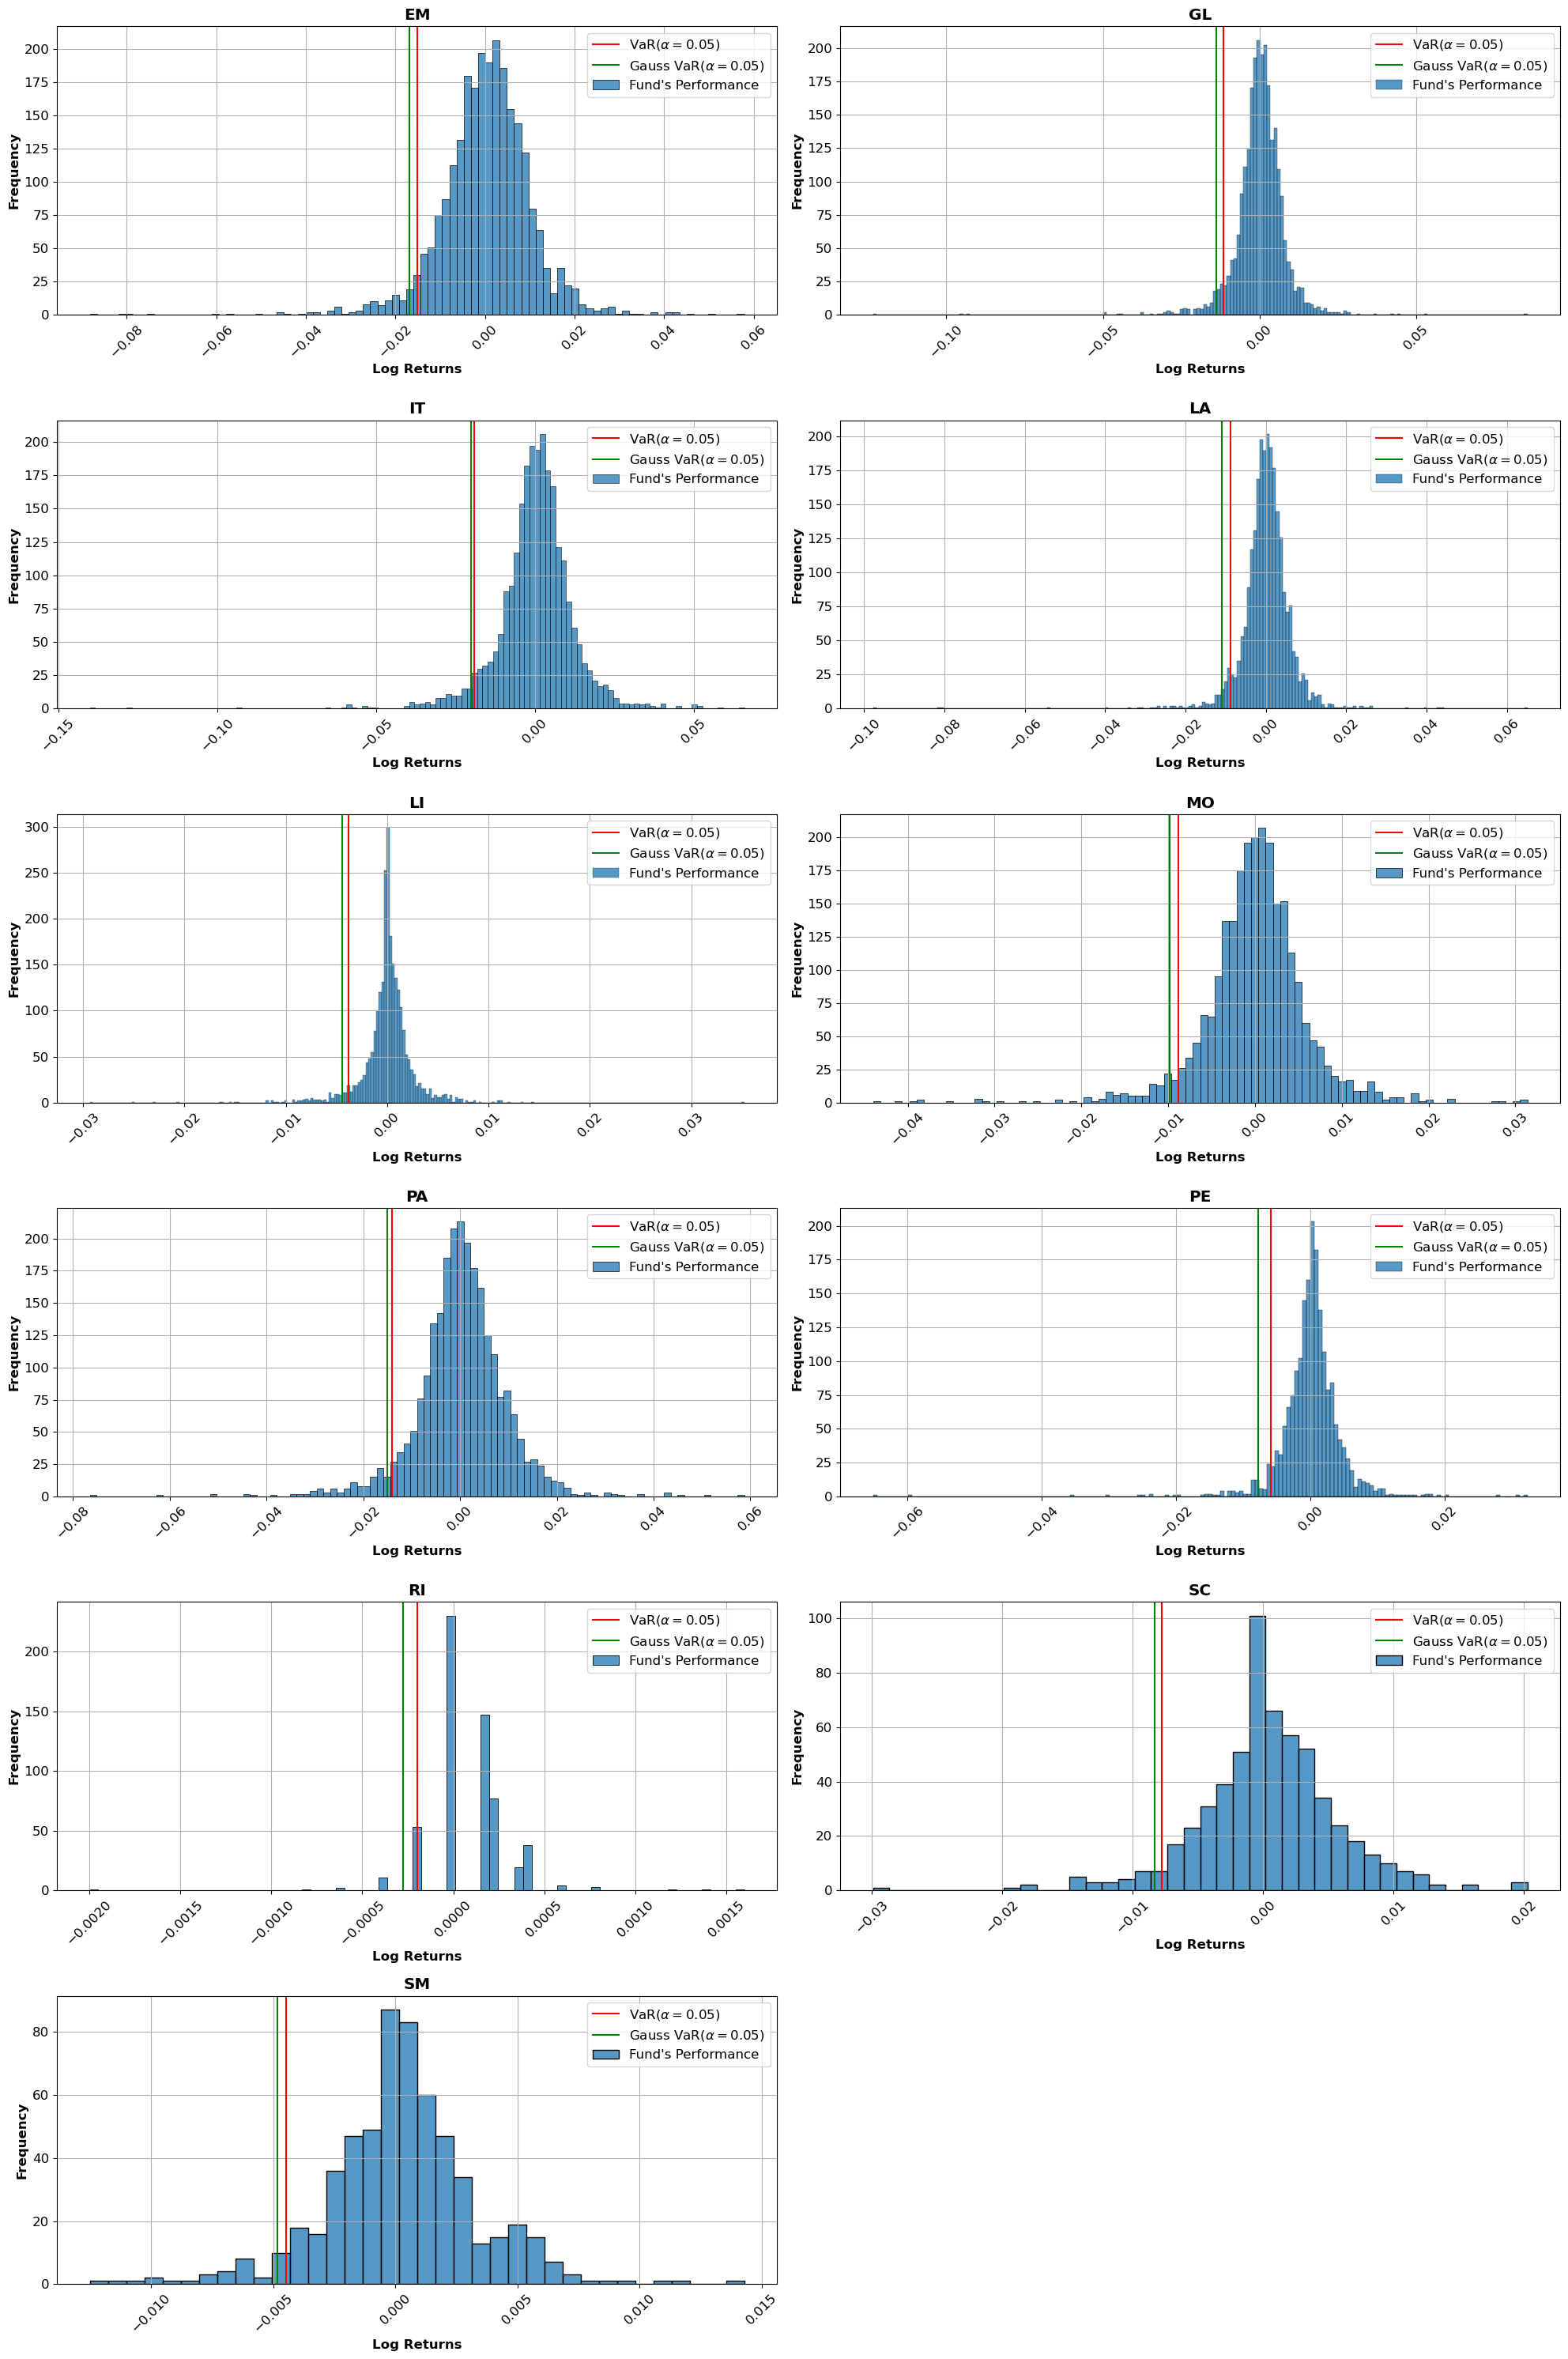

In [14]:
fr.Plot_VaR(df_Log_Returns, Titles, alpha)

# 4) Fund Portfolio

In the following code section, we will evaluate the performance and risk of the portfolio defined as follows:
| Fondo                           | Peso  |
|----------------------------------|-------|
| SGR Paesi Emergenti              | 0.10  |
| SGR Globale                      | 0.20  |
| SGR Italia                       | 0.10  |
| SGR Strategia Dinamica Globale   | 0.10  |
| SGR Breve Termine                | 0.10  |
| SGR Perfromance                  | 0.10  |
| SGR Far East                     | 0.20  |
| Liquidity                        | 0.10  |

**Note:**

Liquidity is defined as an asset uncorrelated with funds and with zero volatility.

In [15]:
portfolio_weights = {
    'SGR Paesi Emergenti': 0.10,
    'SGR Globale': 0.20,
    'SGR Italia': 0.10,
    'SGR Strategia Dinamica Globale': 0.10,
    'SGR Breve Termine': 0.10,
    'SGR Perfromance': 0.10,
    'SGR Far East': 0.20,
    'Liquidity': 0.10
}

weights = []
for key, value in portfolio_weights.items():
    weights.append(value)

### 3-Year Portfolio Performance Calculation (Constant Weights)

Below is the portfolio performance calculation over the last 3 years with an initial capital of €100,000.

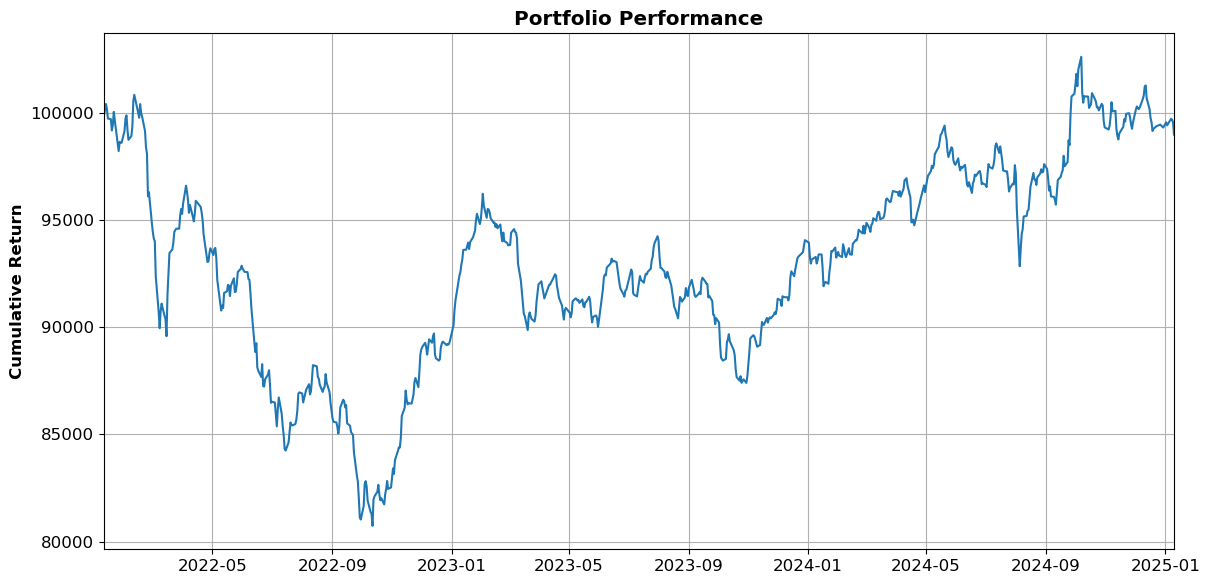

In [16]:
capital = 100000

cash = pd.read_csv("MERG0O1_full_history.csv").drop(columns=["HIGH", "LOW", "OPEN", "VOLUME"]).rename(columns={'CLOSE': 'Cash'})

port = df.drop(columns=["PE", "RI", "SC", "SM"])
port["Date"] = port.index

cash["Date"] = pd.to_datetime(cash['Date'], format='%Y-%m-%d', errors='raise')
port["Date"] = pd.to_datetime(port['Date'], format='%Y-%m-%d', errors='raise')
port.index = np.linspace(0, len(port) - 1, len(port), dtype=int)
port_cash = pd.merge(cash, port, on="Date", how="inner")
port_cash.set_index('Date', inplace=True)

rend = port_cash.pct_change()

rend_2022_2025 = rend.loc["2022-01-10":]

returns = capital * (1 + rend_2022_2025 @ weights).cumprod()
plt.title("Portfolio Performance")
plt.plot(rend_2022_2025.index, returns)
plt.ylabel("Cumulative Return")
plt.tight_layout()
plt.margins(x=0)
plt.grid()
plt.savefig("img/Performance_portfolio.png", dpi=500, bbox_inches='tight')
plt.show()

### Portfolio Return and Volatility Calculation

Daily Return and Volatility

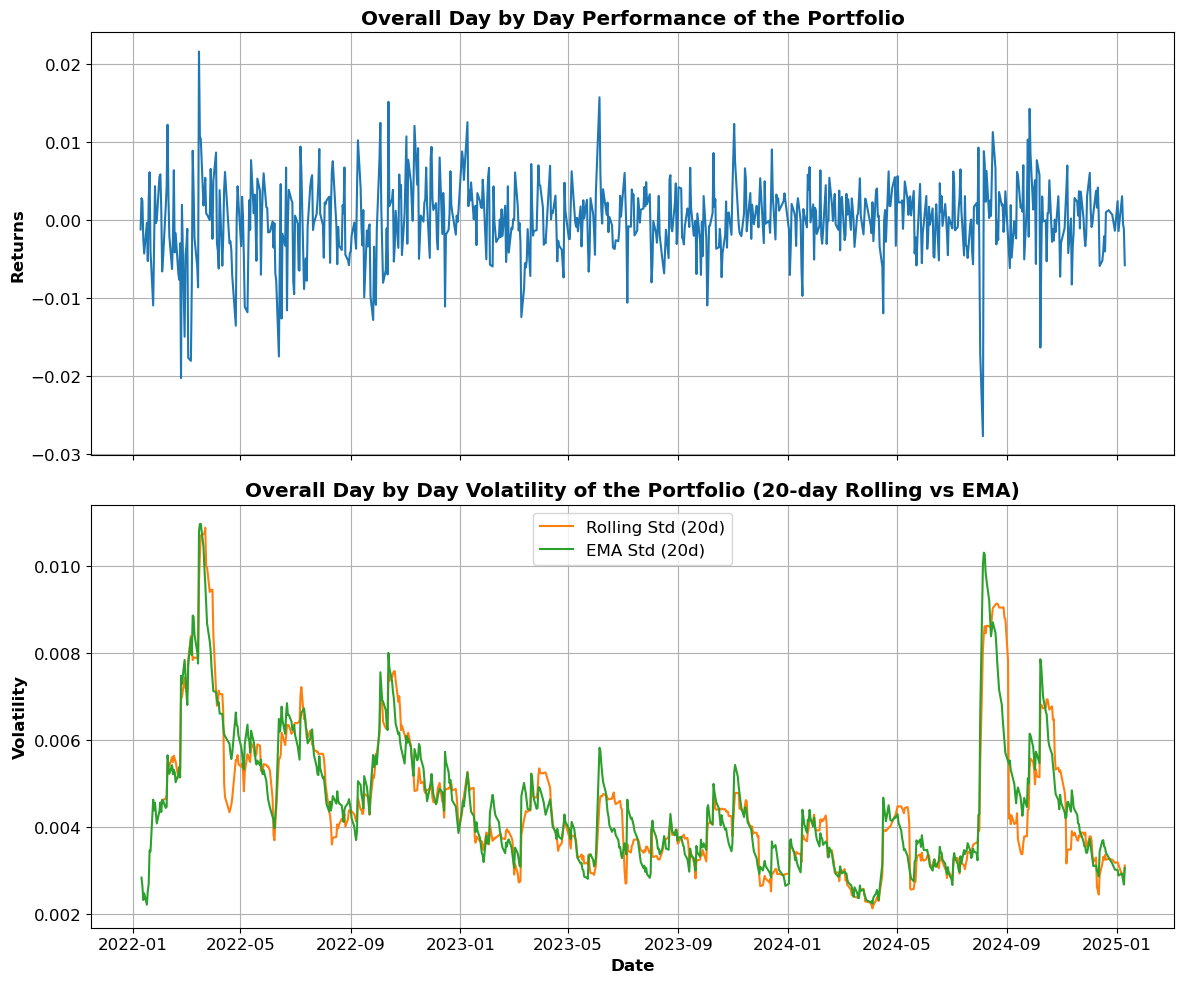

In [17]:
performance = rend_2022_2025 @ weights
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot dei rendimenti
axs[0].set_title("Overall Day by Day Performance of the Portfolio")
axs[0].plot(performance, color='tab:blue')
axs[0].set_ylabel("Returns")
axs[0].grid(True)

# Plot della volatilità rolling e EMA
rolling_vol = performance.rolling(window=20, step=1).std()
ema_vol = performance.ewm(span=20, adjust=False, min_periods=1).std()
axs[1].set_title("Overall Day by Day Volatility of the Portfolio (20-day Rolling vs EMA)")
axs[1].plot(rolling_vol, color='tab:orange', label='Rolling Std (20d)')
axs[1].plot(ema_vol, color='tab:green', label='EMA Std (20d)')
axs[1].set_ylabel("Volatility")
axs[1].set_xlabel("Date")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.savefig("img/log_return&vola_portafolio.png", dpi=300, bbox_inches='tight')
plt.show()


### Portfolio VaR Calculation

Portfolio VaR is calculated using the historical and Gaussian methods.

In [18]:
H_Var = fr.VaR(performance, alpha)
G_Var = fr.gauss_VaR(performance, alpha, T)
print(f"Historical VaR: {H_Var:.2f}, expected loss: {-H_Var * capital:.2f}€")
print(f"Gaussian VaR: {G_Var:.2f}, expected loss: {-G_Var * capital:.2f}€")

Historical VaR: -0.74, expected loss: 73572.68€
Gaussian VaR: -0.80, expected loss: 80231.15€


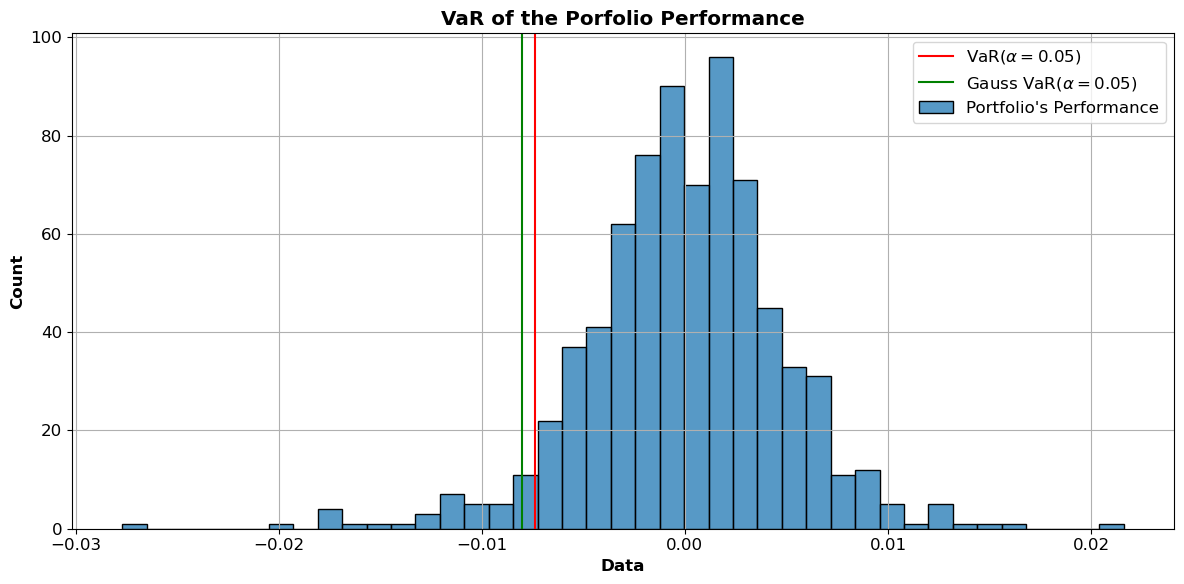

In [19]:
plt.title("VaR of the Porfolio Performance")
sns.histplot(performance, label="Portfolio's Performance")
plt.xlabel("Data")
plt.axvline(fr.VaR(performance, alpha)/100, c="r", label=rf"VaR($\alpha={alpha}$)")
plt.axvline(fr.gauss_VaR(performance, alpha, 1)/100, c="g", label=rf"Gauss VaR($\alpha={alpha}$)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("img/Portfolio_VaR.png", dpi=500, bbox_inches='tight')
plt.show()

### Portfolio Correlation Matrix

Based on the correlation matrix between the components, judge whether the portfolio appears well diversified.

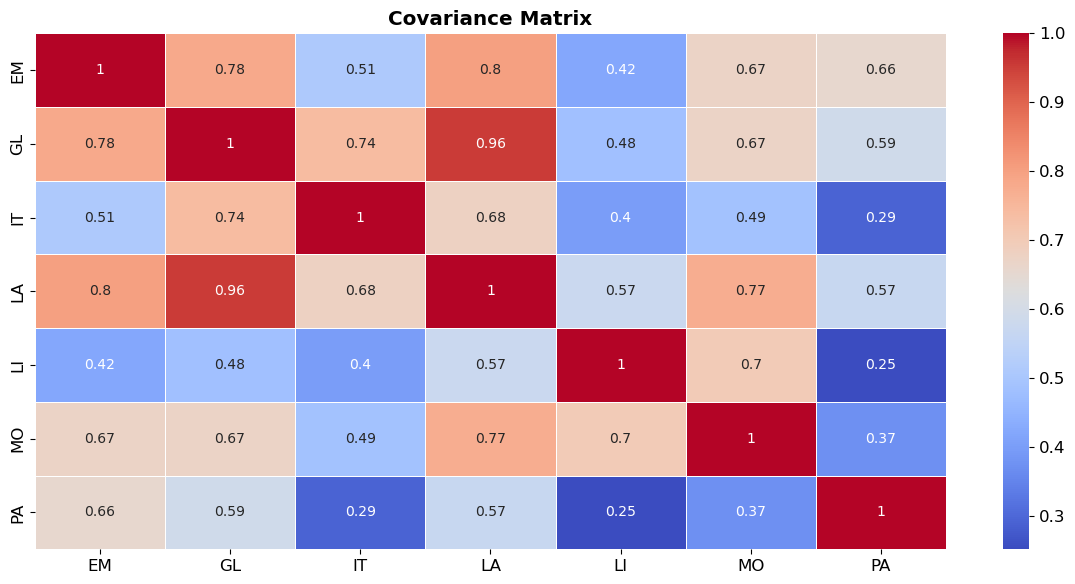

In [20]:
plt.title("Covariance Matrix")
sns.heatmap(
    rend.drop(columns="Cash").corr(),
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()

### Evaluation of Equally Wheighted Portfolio

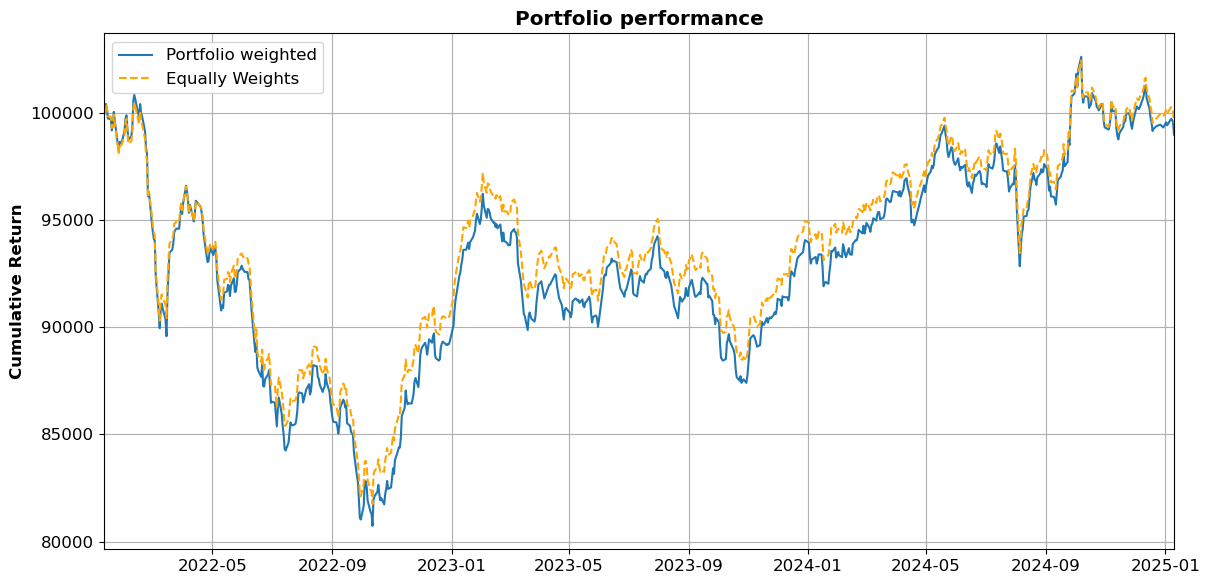

In [21]:
weights_2 = 1/len(port.columns)*np.ones(len(port.columns))  # Equal weights for all funds
returns_eq = capital * (1 + rend_2022_2025 @ weights_2).cumprod()

plt.title("Portfolio performance")
plt.plot(rend_2022_2025.index, returns, label="Portfolio weighted")
plt.plot(rend_2022_2025.index, returns_eq, label="Equally Weights", linestyle='--', color='orange')
plt.legend()
plt.ylabel("Cumulative Return")
plt.tight_layout()
plt.margins(x=0)
plt.grid()
plt.savefig("img/Performance_portfolio_eqvsori.png", dpi=500, bbox_inches='tight')
plt.show()


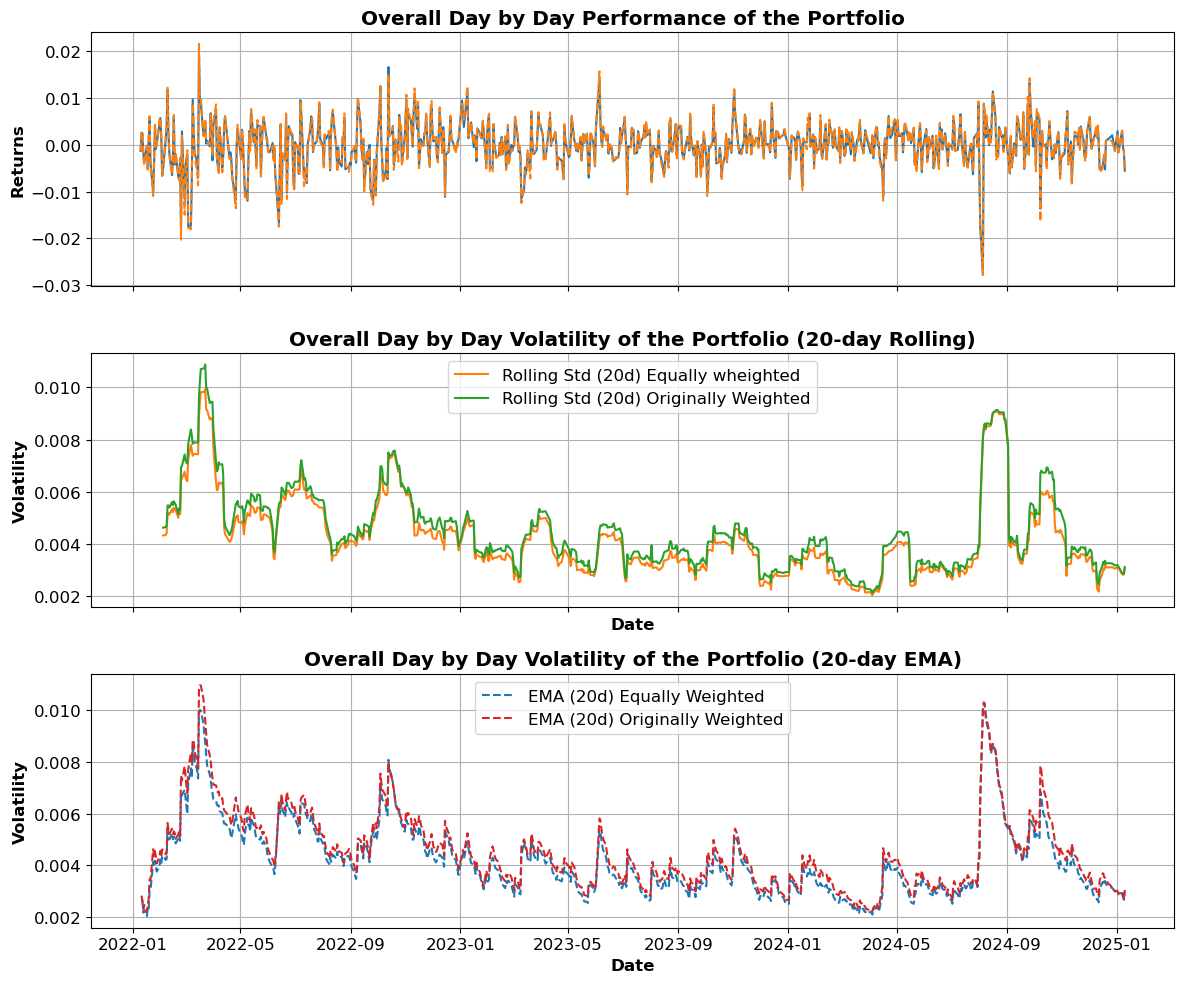

In [22]:
performance_eq = rend_2022_2025 @ weights_2
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Returns plot
axs[0].set_title("Overall Day by Day Performance of the Portfolio")
axs[0].plot(performance_eq, color='tab:blue', label='Equally Weighted Portfolio')
axs[0].plot(performance, color='tab:orange', linestyle='--', label='Weighted Portfolio')
axs[0].set_ylabel("Returns")
axs[0].grid(True)

# Rolling volatility & EMA plot
rolling_vol_eq = performance_eq.rolling(window=20, step=1).std()
ema_vol_eq = performance_eq.ewm(span=20, adjust=False, min_periods=1).std()
rolling_vol = performance.rolling(window=20, step=1).std()
ema_vol = performance.ewm(span=20, adjust=False, min_periods=1).std()

axs[1].set_title("Overall Day by Day Volatility of the Portfolio (20-day Rolling)")
axs[1].plot(rolling_vol_eq, color='tab:orange', label='Rolling Std (20d) Equally wheighted')
axs[1].plot(rolling_vol, color='tab:green', label='Rolling Std (20d) Originally Weighted')

# Weighted Portfolio plot
axs[2].set_title("Overall Day by Day Volatility of the Portfolio (20-day EMA)")
axs[2].plot(ema_vol_eq, color='tab:blue', linestyle='--', label='EMA (20d) Equally Weighted')
axs[2].plot(ema_vol, color='tab:red', linestyle='--', label='EMA (20d) Originally Weighted')

axs[1].set_ylabel("Volatility")
axs[1].set_xlabel("Date")
axs[1].grid(True)
axs[1].legend()

axs[2].set_ylabel("Volatility")
axs[2].set_xlabel("Date")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.savefig("img/log_return&vola_portafolio_eqvsori.png", dpi=300, bbox_inches='tight')
plt.show()


In [23]:
H_Var = fr.VaR(performance_eq, alpha)
G_Var = fr.gauss_VaR(performance_eq, alpha, T)
print(f"Historical VaR: {H_Var:.2f}, expected loss: {-H_Var * capital:.2f}€")
print(f"Gaussian VaR: {G_Var:.2f}, expected loss: {-G_Var * capital:.2f}€")

Historical VaR: -0.72, expected loss: 71597.49€
Gaussian VaR: -0.75, expected loss: 75159.93€


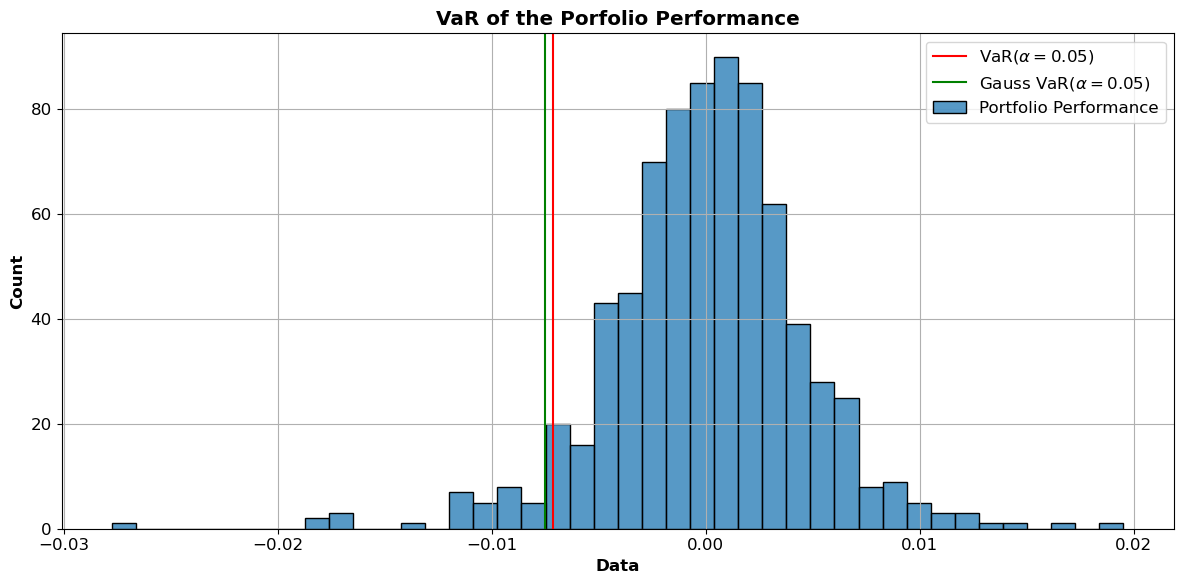

In [24]:
plt.title("VaR of the Porfolio Performance")
sns.histplot(performance_eq, label="Portfolio Performance")
plt.xlabel("Data")
plt.axvline(fr.VaR(performance_eq, alpha)/100, c="r", label=rf"VaR($\alpha={alpha}$)")
plt.axvline(fr.gauss_VaR(performance_eq, alpha, 1)/100, c="g", label=rf"Gauss VaR($\alpha={alpha}$)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("img/Portfolio_VaR_eqvsori.png", dpi=500, bbox_inches='tight')
plt.show()

### 5) Calculation of return scenarios for three types of scenarios:

According to EU Delegated Regulation 2017/653, scenarios are defined as follows:

#### Favourable Scenario

The **favourable scenario** is the PRIIP value at the 90th percentile of an estimated distribution of outcomes over the recommended holding period, net of all applicable costs.

$$
Z_{Score} = 1.28$
$$

#### Moderate Scenario

The **moderate scenario** is the PRIIP value at the 50th percentile of an estimated distribution of outcomes over the recommended holding period, net of all applicable costs.

$$
Z_{Score} = 0
$$

#### Unfavourable Scenario

The **unfavourable scenario** is the PRIIP value at the 10th percentile of an estimated distribution of outcomes over the recommended holding period, net of all applicable costs.

$$
Z_{Score} = -1.28
$$

## Cornish-Fisher Formula

The **Cornish-Fisher formula** was used to calculate the scenarios. This formula takes into account moments greater than one second for the VaR calculation, thus correcting the normal distribution values for kurtosis and skewness.

The Cornish-Fisher formula for adjusting the normal quantile is:

$$
z_{CF} = z + \frac{1}{6}(z^2 - 1)S + \frac{1}{24}(z^3 - 3z)K - \frac{1}{36}(2z^3 - 5z)S^2
$$

**Where:**
- **z** = quantile of the standard normal distribution
- **S** = coefficient of skewness
- **K** = coefficient of excess kurtosis
- $z_{CF}$ = Cornish-Fisher-corrected quantile

**Note:** The Cornish-Fisher correction is particularly important when the return distribution exhibits significant skewness or high kurtosis, situations common in financial markets that deviate from the normality assumption.

In [25]:
for i in df_Log_Returns.columns:
    data = df_Log_Returns[i].dropna()
    
    # Check if there is enough data to compute statistics
    if len(data) >= 252 * 5:
        # Basic calculations
        mean = data.mean()                     # Mean of log-returns (μ₁)
        std = data.std()                       # Standard deviation (σ)
        N = 1                                   # Number of annual observations (trading days)

        # Higher-order moments for Cornish-Fisher expansion
        mu3 = ((data - mean) ** 3).mean()      # Third central moment (non-standardized skewness)
        mu4 = ((data - mean) ** 4).mean()      # Fourth central moment (non-standardized kurtosis)

        # Parameters for Cornish-Fisher expansion
        skewness = mu3 / (std ** 3)            # Standardized skewness
        excess_kurtosis = (mu4 / (std ** 4)) - 3  # Excess kurtosis

        # Compute favorable scenario (90th percentile)
        z_alpha_90 = 1.2816                    # Z-score for 90th percentile
        cornish_fisher_z_90 = (
            z_alpha_90 +
            (z_alpha_90**2 - 1) * skewness / 6 +
            (z_alpha_90**3 - 3*z_alpha_90) * excess_kurtosis / 24 -
            (2*z_alpha_90**3 - 5*z_alpha_90) * skewness**2 / 36
        )
        exp_value_90 = mean * N + std * np.sqrt(N) * cornish_fisher_z_90
        scenario_90 = np.exp(exp_value_90) - 1  # Convert to percentage

        # Compute unfavorable scenario (10th percentile)
        z_alpha_10 = -1.2816                   # Z-score for 10th percentile
        cornish_fisher_z_10 = (
            z_alpha_10 +
            (z_alpha_10**2 - 1) * skewness / 6 +
            (z_alpha_10**3 - 3*z_alpha_10) * excess_kurtosis / 24 -
            (2*z_alpha_10**3 - 5*z_alpha_10) * skewness**2 / 36
        )
        exp_value_10 = mean * N + std * np.sqrt(N) * cornish_fisher_z_10
        scenario_10 = np.exp(exp_value_10) - 1  # Convert to percentage

        # Compute moderate scenario (50th percentile - median)
        exp_value_50 = mean * N - (std * mean) / 6 - 0.5 * (std ** 2) * N
        scenario_50 = np.exp(exp_value_50) - 1  # Convert to percentage

        z_alpha_025 = -1.96                     # Z-score for 2.5th percentile

        # Cornish-Fisher correction for VaR
        cornish_fisher_z_025 = (
            z_alpha_025 +
            (z_alpha_025**2 - 1) * skewness / 6 +
            (z_alpha_025**3 - 3*z_alpha_025) * excess_kurtosis / 24 -
            (2*z_alpha_025**3 - 5*z_alpha_025) * skewness**2 / 36
        )
        # Compute adjusted quantile
        log_return_quantile = mean * N + std * np.sqrt(N) * cornish_fisher_z_025
        var_975 = 1 - np.exp(log_return_quantile)  # Loss in percentage

        # Annualized market risk volatility (MRM)
        market_volatility = abs(var_975)

        # Print results
        print(f"Title: {i}")
        print(f"Favorable Scenario: {100 * scenario_90:.6f}%")
        print(f"Unfavorable Scenario: {100 * scenario_10:.6f}%")
        print(f"Moderate Scenario: {100 * scenario_50:.6f}%")
        print(f"97.5% VaR: {100 * var_975:.6f}%")

        # Determine market risk measure class (MRM) based on volatility
        market_volatility *= 100  # Convert to percentage
        if market_volatility < 0.5:
            print(f"MRM class for fund {i}: 1 (Very low market risk)")
        elif 0.5 <= market_volatility < 2:
            print(f"MRM class for fund {i}: 2 (Low market risk)")
        elif 2 <= market_volatility < 5:
            print(f"MRM class for fund {i}: 3 (Moderate risk)")
        elif 5 <= market_volatility < 10:
            print(f"MRM class for fund {i}: 4 (Medium-high risk)")
        elif 10 <= market_volatility < 15:
            print(f"MRM class for fund {i}: 5 (High risk)")
        elif 15 <= market_volatility < 25:
            print(f"MRM class for fund {i}: 6 (Very high market risk)")
        elif market_volatility >= 25:
            print(f"MRM class for fund {i}: 7 (Extremely high market risk)")
        print("-" * 50)

    else:
        print(f"Title {i} does not have enough data to compute statistics.")
        print("-" * 50)
        
#############################################################################

#  MRM class calculation for columns from index 8 

for i in df_Log_Returns.columns[8:]:
    data = df_Log_Returns[i].dropna()
    mean = data.mean()                         # Mean of log-returns (μ₁)
    std = data.std()                           # Standard deviation (σ)
    N = 1

    # Higher-order moments
    mu3 = ((data - mean) ** 3).mean()
    mu4 = ((data - mean) ** 4).mean()
    skewness = mu3 / (std ** 3) if std != 0 else 0
    excess_kurtosis = (mu4 / (std ** 4)) - 3 if std != 0 else 0

    z_alpha_025 = -1.96
    cornish_fisher_z_025 = (
        z_alpha_025 +
        (z_alpha_025**2 - 1) * skewness / 6 +
        (z_alpha_025**3 - 3*z_alpha_025) * excess_kurtosis / 24 -
        (2*z_alpha_025**3 - 5*z_alpha_025) * skewness**2 / 36
    )

    log_return_quantile = mean * N + std * np.sqrt(N) * cornish_fisher_z_025
    var_975 = 1 - np.exp(log_return_quantile)

    market_volatility = abs(var_975) * 100

    if market_volatility < 0.5:
        print(f"MRM class for fund {i}: 1 (Very low market risk) {market_volatility:.2f}%")
    elif 0.5 <= market_volatility < 2:
        print(f"MRM class for fund {i}: 2 (Low market risk) {market_volatility:.2f}%")
    elif 2 <= market_volatility < 5:
        print(f"MRM class for fund {i}: 3 (Moderate risk) {market_volatility:.2f}%")
    elif 5 <= market_volatility < 10:
        print(f"MRM class for fund {i}: 4 (Medium-high risk) {market_volatility:.2f}%")
    elif 10 <= market_volatility < 15:
        print(f"MRM class for fund {i}: 5 (High risk) {market_volatility:.2f}%")
    elif 15 <= market_volatility < 25:
        print(f"MRM class for fund {i}: 6 (Very high market risk) {market_volatility:.2f}%")
    elif market_volatility >= 25:
        print(f"MRM class for fund {i}: 7 (Extremely high market risk) {market_volatility:.2f}%")
    print("-" * 50)


Title: EM
Favorable Scenario: 0.668642%
Unfavorable Scenario: -0.836844%
Moderate Scenario: 0.013530%
97.5% VaR: 2.910830%
MRM class for fund EM: 3 (Moderate risk)
--------------------------------------------------
Title: GL
Favorable Scenario: -1.107045%
Unfavorable Scenario: 0.752122%
Moderate Scenario: 0.011309%
97.5% VaR: 4.000311%
MRM class for fund GL: 3 (Moderate risk)
--------------------------------------------------
Title: IT
Favorable Scenario: 0.215682%
Unfavorable Scenario: -0.570085%
Moderate Scenario: 0.003048%
97.5% VaR: 4.075793%
MRM class for fund IT: 3 (Moderate risk)
--------------------------------------------------
Title: LA
Favorable Scenario: -1.135007%
Unfavorable Scenario: 0.814890%
Moderate Scenario: 0.006535%
97.5% VaR: 3.418866%
MRM class for fund LA: 3 (Moderate risk)
--------------------------------------------------
Title: LI
Favorable Scenario: -0.196635%
Unfavorable Scenario: 0.156548%
Moderate Scenario: 0.003445%
97.5% VaR: 1.105956%
MRM class for fun